In [8]:
import os
import matplotlib.pyplot as plt

plt.style.use("default")

os.chdir("/home/wpkim/snuh")
print(os.getcwd())

/home/wpkim/snuh


# Figure 2 - Best Model ROC

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from functools import reduce

import pyarrow.feather as feather

from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import joblib
import shap
import scipy.stats

import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use("default")

/home/wpkim/anaconda3/envs/py37_snuh/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DeLong test

In [3]:
import os
import numpy as np
import pandas as pd

from functools import reduce
from IPython.core.display import display, HTML

from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.inspection import permutation_importance

import glob
import shap
import joblib
import datetime
from tqdm import tqdm

import xgboost as xgb
import lightgbm as lgb
import multiprocessing as mp

import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [4]:
class CoreUtils():
    def __init__(self):
        pass

    def check_label_ratio(self, df, column):
        neg, pos = np.bincount(df[column])
        total = neg + pos
        print("{}\n    Total: {}\n    Nagatives: {}\n    Positives: {} ({:.2f}% of dataframe)\n".format(
            column, total, neg, pos, (pos / total * 100)
        ))

    def check_valid_model(self, model, X, y, t_se, t_sp, verbose=False):
        y_pred = model.predict_proba(X)[:, 1]
        y_pred = (y_pred >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        if verbose:
            print("Sensitivity: {:.3f}, Specificity: {:.3f}".format(sensitivity, specificity))

        if (sensitivity >= t_se) & (specificity >= t_sp):
            return True
        else:
            return False

    def compute_model_performance(self, model, X, y, youden=False):
        y_pred = model.predict_proba(X)[:, 1]

        fpr, tpr, thresholds = roc_curve(y, y_pred)
        auroc = auc(fpr, tpr)

        if youden:
            J = tpr - fpr
            ix = np.argmax(J)
            best_threshold = thresholds[ix]

            y_pred = (y_pred >= best_threshold).astype(int)
        else:
            y_pred = (y_pred >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        accuracy = (tp + tn) / (tp + fn + fp + tn)
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp)
        f1 = (2 * precision * sensitivity) / (precision + sensitivity)
        f2 = (5 * precision * sensitivity) / (4 * precision + sensitivity)

        npv = tn / (tn + fn)
        odd_ratio = (tp * tn) / (fp * fn)

        if youden:
            return pd.DataFrame(
                [best_threshold, auroc, accuracy, precision, sensitivity, specificity, f1, npv, odd_ratio]
            ).T
           
        else:
            return pd.DataFrame([auroc, accuracy, precision, sensitivity, specificity, f1, npv, odd_ratio]).T


    def compute_model_tprs(self, model, X_train, y_train, X_test, y_test):
        mean_fpr = np.linspace(0, 1, 100)

        train_tprs, test_tprs = [], []

        y_train_pred = model.predict_proba(X_train)[:, 1]
        y_test_pred = model.predict_proba(X_test)[:, 1]

        train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred)
        test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred)

        train_auroc = auc(train_fpr, train_tpr)
        test_auroc = auc(test_fpr, test_tpr)

        train_tprs.append(np.interp(mean_fpr, train_fpr, train_tpr))
        train_tprs[-1][0] = 0.0
        train_tprs = np.mean(train_tprs, axis=0)

        test_tprs.append(np.interp(mean_fpr, test_fpr, test_tpr))
        test_tprs[-1][0] = 0.0
        test_tprs = np.mean(test_tprs, axis=0)

        return pd.DataFrame([train_tprs, test_tprs, [train_auroc], [test_auroc]]).T


    def compute_shap_values(self, model, X_test, mode):
        feature_names = X_test.columns

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        if mode == "rf" or mode == "lgb":
            model_shap = pd.DataFrame(
                list(
                    zip(
                        feature_names, np.abs(pd.DataFrame(shap_values[1], columns=feature_names).values).mean(0)
                    )
                ),
                columns=["columns", "shap_values"]
            )
        elif mode == "xgb":
            model_shap = pd.DataFrame(
                list(
                    zip(
                        feature_names, np.abs(pd.DataFrame(shap_values, columns=feature_names).values).mean(0)
                    )
                ),
                columns=["columns", "shap_values"]
            )

        return model_shap.sort_values(by=["shap_values"], ascending=False)

In [5]:
class SNUHStroke():
    def __init__(self, kfold=True, model_save=False, debug=False, shap=False, feature_importance=False):
        self.cores = CoreUtils()

        self.PATH_DATASET = None
        self.PATH_SAVE = None

        self.WITH_KFOLD = kfold
        self.WITH_SAVE = model_save
        self.WITH_MODEL_DEBUG = debug
        self.WITH_SHAP = shap
        self.WITH_FEATURE_IMPORTANCE = feature_importance

        self.c_pre, c_post = [], []
        self.c_hours = []

        self.df = None

        self.df_ttest_tp = None
        self.df_ttest_mean = None
        self.df_ttest_std = None

        self.df_train = None
        self.df_test = None
        self.X_train, self.y_train = None, None
        self.X_test, self.y_test = None, None

        self.rf_summary, self.rf_tprs, self.rf_summary_youden = [], [], []
        self.rf_shap, self.rf_feature_importance, self.rf_permute_importance = [], [], []
        self.xgb_summary, self.xgb_tprs, self.xgb_summary_youden = [], [], []
        self.xgb_shap, self.xgb_feature_importance, self.xgb_permute_importance = [], [], []
        self.lgb_summary, self.lgb_tprs, self.lgb_summary_youden = [], [] ,[]
        self.lgb_shap, self.lgb_feature_importance, self.lgb_permute_importance = [], [], []

        self.rf_val_summary, self.rf_val_tprs = [], []
        self.xgb_val_summary, self.xgb_val_tprs = [], []
        self.lgb_val_summary, self.lgb_val_tprs = [], []


    def set_path(self, path_dataset, path_save):
        self.PATH_DATASET = path_dataset
        self.PATH_SAVE = path_save


    def load_dataset(self):
        try:
            df = pd.read_csv(self.PATH_DATASET, sep=",")
        except:
            print("Error to open file")
            raise
        print(np.unique(df["caseid"]).shape)

        df["sum_rbc_my"] = df["sum_rbc_my"].fillna(0)
        df["sum_tf"] = df["sum_ffp"] + df["sum_plt"] + df["sum_cryo"] + df["sum_rbc_my"]
        df["sum_io"] = df["sum_fluid"] - (df["sum_uo"] + df["sum_ebl"])

        self.df = df.copy()


    def drop_exclusion(self):
        df = self.df.copy()

        ## ART
        query = "exclusion_art_not_exist == 1"
        df = df.drop(index=df.query(query).index)
        print(df.shape, df.query("is_stroke == 1").shape)

        ## DONOR
        query = "exclusion_cardiovascular_surgery_deceased_donor == 1"
        df = df.drop(index=df.query(query).index)
        print(df.shape, df.query("is_stroke == 1").shape)

        exclusion_keys = [
            5760, 9660, 11987, 11996, 12887, 13469, 15255, 15257, 16607, 17914, 19017,
            19613, 20023, 28712, 29092, 30743, 30872, 33686, 33751, 36408, 36409, 38631, 38680
        ]
        query = "caseid == @exclusion_keys"
        df = df.drop(index=df.query(query).index)
        print(df.shape, df.query("is_stroke == 1").shape)

        ## exclusion age
        query = "age < 18"
        df = df.drop(index=df.query(query).index)
        print(df.shape, df.query("is_stroke == 1").shape)

        ## exclusion weight
        query = "weight < 30 | weight >= 140"
        df = df.drop(index=df.query(query).index)
        print(df.shape, df.query("is_stroke == 1").shape)

        ## exclusion height
        query = "height < 135 | height >= 200"
        df = df.drop(index=df.query(query).index)
        print(df.shape, df.query("is_stroke == 1").shape)

        ## exclusion op duration
        query = "opdur_cal_sm2 <= 20"
        df = df.drop(index=df.query(query).index)
        print(df.shape, df.query("is_stroke == 1").shape)

        self.df = df.copy()


    def set_features(self):
        df = self.df.copy()

        self.c_basic = [
            "caseid", "patientid", "opname"
        ]

        self.c_pre = [
            "age", "sex",
            "height", "weight", "bmi",
            "preop_asa", "preop_emop",
            "preop_htn", "preop_dm", "preop_cva", "preop_asthma", "preop_copd",
            "preop_liverds", "preop_kidneyds", "preop_tb", "preop_hb_my", "preop_plt_sm",
            "preop_cr_sm", "preop_na", "preop_alb", "preop_bun", "preop_k_sm",
            "preop_pt", "preop_ptt_sm", "preop_glucose_sm", "preop_gpt_sm", "preop_got",
            "preop_egfr"
        ]
        self.c_post = [
            "opdur_cal_sm2", "andur_cal_my",
            "sum_uo", "sum_ebl", "sum_crystalloid", "sum_colloid", "sum_fluid", "sum_rbc_my",
            "sum_ffp", "sum_plt", "sum_cryo", "sum_tf", "sum_io",

            "SBP_below100", "SBP_below95", "SBP_below90", "SBP_below85", "SBP_below80",
            "SBP_below75", "SBP_below70", "SBP_below65", "SBP_below60", "SBP_below55",
            "SBP_below50", "SBP_mean", "SBP_std",

            "DBP_below70", "DBP_below65", "DBP_below60", "DBP_below55", "DBP_below50",
            "DBP_below45", "DBP_below40", "DBP_below35", "DBP_below30", "DBP_below25",
            "DBP_below20", "DBP_mean", "DBP_std",

            "SPO2_below95", 
            "SPO2_mean", "SPO2_std",

            "HR_above100", "HR_above105", "HR_above110", "HR_above115", "HR_above120",
            "HR_above125", "HR_above130", "HR_above135", "HR_above140", "HR_above145",
            "HR_above150", "HR_below60", "HR_below55", "HR_below50", "HR_below45",
            "HR_below40", "HR_below35", "HR_mean", "HR_std",
        ]

       
        df = df[self.c_basic + self.c_pre + self.c_post + ["opyear", "is_stroke"]]

        self.df = df.copy()


    def fill_features(self, mode):
        df = self.df.copy()

        df["sex"] = pd.get_dummies(df["sex"])["M"]
        df["preop_asa"] = df["preop_asa"].fillna(0)
        df["preop_emop"] = pd.get_dummies(df["preop_emop"].fillna("N"))["Y"]

        query = "preop_hb_my == '18.818.8'"
        df.loc[df.query(query).index, "preop_hb_my"] = 18.8
        df["preop_hb_my"] = df["preop_hb_my"].astype(float)

        query = "preop_na == '.'"
        df.loc[df.query(query).index, "preop_na"] = 0.0
        df["preop_na"] = df["preop_na"].astype(float)

        df = df.dropna()

        

        if mode == "pp":
            df = df[self.c_pre + self.c_post + ["opyear", "is_stroke"]]
            print(df.shape)
        elif mode == "p":
            df = df[self.c_pre + ["opyear", "is_stroke"]]
            print(df.shape)
        elif mode == "i":
            df = df[self.c_post + ["opyear", "is_stroke"]]
            print(df.shape)
        elif mode == "custom":
            df = df[self.c_basic + self.c_pre + self.c_post + ["opyear", "is_stroke"]]
            print(df.shape)
        else:
            print("??")
            raise

        
        self.df = df.copy()

    def compute_ttest(self):
        df = self.df.copy()

        query = "is_stroke == 0"
        df_control = df.query(query).drop(columns=["is_stroke"]).reset_index(drop=True)
        query = "is_stroke == 1"
        df_target = df.query(query).drop(columns=["is_stroke"]).reset_index(drop=True)

        li = []
        for column in df_control.columns:
            ret = stats.ttest_ind(df_control[column], df_target[column], equal_var=True)
            li.append([column, "{:.5f}".format(ret[0]), "{:.5f}".format(ret[1])])

        self.df_ttest_tp = pd.DataFrame(li, columns=["feature_name", "t_value", "p_value"])

        self.df_ttest_mean = pd.concat(
            [pd.DataFrame(np.mean(df_control), columns=["control"]),
             pd.DataFrame(np.mean(df_target), columns=["is_stroke"])],
            axis=1
        )

        self.df_ttest_std = pd.concat(
            [pd.DataFrame(np.std(df_control), columns=["control"]),
             pd.DataFrame(np.std(df_target), columns=["is_stroke"])],
            axis=1
        )

    def train_test_split(self):
        df = self.df.copy()

        query = "opyear < 19"
        self.df_train = df.query(query).reset_index(drop=True)
        query = "opyear == 19"
        self.df_test = df.query(query).reset_index(drop=True)
        print("Data shape: {} {}".format(self.df_train.shape, self.df_test.shape))

        self.X_train = self.df_train.drop(columns=["opyear", "is_stroke"])
        self.y_train = self.df_train["is_stroke"]
        self.X_test = self.df_test.drop(columns=["opyear", "is_stroke"])
        self.y_test = self.df_test["is_stroke"]
        print(self.X_train.shape, self.y_train.shape, self.X_test.shape, self.y_test.shape)

    def recheck(self, PATH_MODEL_SAVED):
        self.rf_summary, self.rf_tprs, self.rf_summary_youden, self.rf_shap = [], [], [], []
        self.xgb_summary, self.xgb_tprs, self.xgb_summary_youden, self.xgb_shap = [], [], [], []
        self.lgb_summary, self.lgb_tprs, self.lgb_summary_youden, self.lgb_shap = [], [], [], []

        li_rf, li_xgb, li_lgb = [], [], []
        for file in glob.glob(os.path.join(PATH_MODEL_SAVED)):
            if "rf_" in file:
                li_rf.append(file)
            elif "xgb_" in file:
                li_xgb.append(file)
            elif "lgb_" in file:
                li_lgb.append(file)
            else:
                pass
        li_rf.sort(), li_xgb.sort(), li_lgb.sort()

        for file in li_rf:
            print(file)
            model = joblib.load(file)
            self.rf_model = model

            self.rf_summary.append(self.cores.compute_model_performance(model, self.X_test, self.y_test))
            self.rf_tprs.append(self.cores.compute_model_tprs(model, self.X_train, self.y_train, self.X_test, self.y_test))
            self.rf_summary_youden.append(self.cores.compute_model_performance(model, self.X_test, self.y_test, youden=True))

            if self.WITH_SHAP:
                self.rf_shap.append(self.cores.compute_shap_values(model, self.X_test, "rf"))
            if self.WITH_FEATURE_IMPORTANCE:
                self.rf_feature_importance.append(pd.DataFrame(np.concatenate([model.feature_names_in_.reshape(-1, 1), model.feature_importances_.reshape(-1, 1)], axis=1)))
                results = permutation_importance(model, self.X_test, self.y_test, scoring="neg_mean_squared_error")
                self.rf_permute_importance.append(pd.DataFrame(np.concatenate([model.feature_names_in_.reshape(-1, 1), results.importances_mean.reshape(-1, 1)], axis=1)))

        for file in li_xgb:
            print(file)
            model = joblib.load(file)
            self.xgb_model = model

            self.xgb_summary.append(self.cores.compute_model_performance(model, self.X_test, self.y_test))
            self.xgb_tprs.append(self.cores.compute_model_tprs(model, self.X_train, self.y_train, self.X_test, self.y_test))
            self.xgb_summary_youden.append(self.cores.compute_model_performance(model, self.X_test, self.y_test, youden=True))

            if self.WITH_SHAP:
                self.xgb_shap.append(self.cores.compute_shap_values(model, self.X_test, "xgb"))
            if self.WITH_FEATURE_IMPORTANCE:
                self.xgb_feature_importance.append(pd.DataFrame(np.concatenate([model.feature_names_in_.reshape(-1, 1), model.feature_importances_.reshape(-1, 1)], axis=1)))
                results = permutation_importance(model, self.X_test, self.y_test, scoring="neg_mean_squared_error")
                self.xgb_permute_importance.append(pd.DataFrame(np.concatenate([model.feature_names_in_.reshape(-1, 1), results.importances_mean.reshape(-1, 1)], axis=1)))

        for file in li_lgb:
            print(file)
            model = joblib.load(file)
            self.lgb_model = model

            self.lgb_summary.append(self.cores.compute_model_performance(model, self.X_test, self.y_test))
            self.lgb_tprs.append(self.cores.compute_model_tprs(model, self.X_train, self.y_train, self.X_test, self.y_test))
            self.lgb_summary_youden.append(self.cores.compute_model_performance(model, self.X_test, self.y_test, youden=True))

            if self.WITH_SHAP:
                self.lgb_shap.append(self.cores.compute_shap_values(model, self.X_test, "lgb"))
            if self.WITH_FEATURE_IMPORTANCE:
                self.lgb_feature_importance.append(pd.DataFrame(np.concatenate([np.array(model.feature_name_).reshape(-1, 1), model.feature_importances_.reshape(-1, 1)], axis=1)))
                results = permutation_importance(model, self.X_test, self.y_test, scoring="neg_mean_squared_error")
                self.lgb_permute_importance.append(pd.DataFrame(np.concatenate([np.array(model.feature_name_).reshape(-1, 1), results.importances_mean.reshape(-1, 1)], axis=1)))

    # AUC comparison adapted from
    # https://github.com/Netflix/vmaf/
    def compute_midrank(self, x):
        """Computes midranks.
        Args:
           x - a 1D numpy array
        Returns:
           array of midranks
        """
        J = np.argsort(x)
        Z = x[J]
        N = len(x)
        T = np.zeros(N, dtype=np.float)
        i = 0
        while i < N:
            j = i
            while j < N and Z[j] == Z[i]:
                j += 1
            T[i:j] = 0.5*(i + j - 1)
            i = j
        T2 = np.empty(N, dtype=np.float)
        # Note(kazeevn) +1 is due to Python using 0-based indexing
        # instead of 1-based in the AUC formula in the paper
        T2[J] = T + 1
        return T2

    def compute_midrank_weight(self, x, sample_weight):
        J = np.argsort(x)
        Z = x[J]
        cumulative_weight = np.cumsum(sample_weight[J])
        N = len(x)
        T = np.zeros(N, dtype=np.float)
        i = 0
        while i < N:
            j = i
            while j < N and Z[j] == Z[i]:
                j += 1
            T[i:j] = cumulative_weight[i:j].mean()
            i = j
        T2 = np.empty(N, dtype=np.float)
        T2[J] = T
        return T2

    def fastDeLong(self, predictions_sorted_transposed, label_1_count, sample_weight):
        if sample_weight is None:
            return self.fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
        else:
            return self.fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)

    def fastDeLong_weights(self, predictions_sorted_transposed, label_1_count, sample_weight):
        # Short variables are named as they are in the paper
        m = label_1_count
        n = predictions_sorted_transposed.shape[1] - m
        positive_examples = predictions_sorted_transposed[:, :m]
        negative_examples = predictions_sorted_transposed[:, m:]
        k = predictions_sorted_transposed.shape[0]

        tx = np.empty([k, m], dtype=np.float)
        ty = np.empty([k, n], dtype=np.float)
        tz = np.empty([k, m + n], dtype=np.float)
        for r in range(k):
            tx[r, :] = self.compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
            ty[r, :] = self.compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
            tz[r, :] = self.compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
        total_positive_weights = sample_weight[:m].sum()
        total_negative_weights = sample_weight[m:].sum()
        pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
        total_pair_weights = pair_weights.sum()
        aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
        v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
        v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
        sx = np.cov(v01)
        sy = np.cov(v10)
        delongcov = sx / m + sy / n
        return aucs, delongcov

    def fastDeLong_no_weights(self, predictions_sorted_transposed, label_1_count):
        """
        The fast version of DeLong's method for computing the covariance of
        unadjusted AUC.
        Args:
           predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
              sorted such as the examples with label "1" are first
        Returns:
           (AUC value, DeLong covariance)
        Reference:
         @article{sun2014fast,
           title={Fast Implementation of DeLong's Algorithm for
                  Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
           author={Xu Sun and Weichao Xu},
           journal={IEEE Signal Processing Letters},
           volume={21},
           number={11},
           pages={1389--1393},
           year={2014},
           publisher={IEEE}
         }
        """
        # Short variables are named as they are in the paper
        m = label_1_count
        n = predictions_sorted_transposed.shape[1] - m
        positive_examples = predictions_sorted_transposed[:, :m]
        negative_examples = predictions_sorted_transposed[:, m:]
        k = predictions_sorted_transposed.shape[0]

        tx = np.empty([k, m], dtype=np.float)
        ty = np.empty([k, n], dtype=np.float)
        tz = np.empty([k, m + n], dtype=np.float)
        for r in range(k):
            tx[r, :] = self.compute_midrank(positive_examples[r, :])
            ty[r, :] = self.compute_midrank(negative_examples[r, :])
            tz[r, :] = self.compute_midrank(predictions_sorted_transposed[r, :])
        aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
        v01 = (tz[:, :m] - tx[:, :]) / n
        v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
        sx = np.cov(v01)
        sy = np.cov(v10)
        delongcov = sx / m + sy / n
        return aucs, delongcov


    def calc_pvalue(self, aucs, sigma):
        """Computes log(10) of p-values.
        Args:
           aucs: 1D array of AUCs
           sigma: AUC DeLong covariances
        Returns:
           log10(pvalue)
        """
        l = np.array([[1, -1]])
        z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
        p = 2 * (1 - scipy.stats.norm.cdf(z, loc=0, scale=1))
        return z, p

    
    def compute_ground_truth_statistics(self, ground_truth, sample_weight):
        assert np.array_equal(np.unique(ground_truth), [0, 1])
        order = (-ground_truth).argsort()
        label_1_count = int(ground_truth.sum())
        if sample_weight is None:
            ordered_sample_weight = None
        else:
            ordered_sample_weight = sample_weight[order]

        return order, label_1_count, ordered_sample_weight


    def delong_roc_variance(self, ground_truth, predictions, sample_weight=None):
        """
        Computes ROC AUC variance for a single set of predictions
        Args:
           ground_truth: np.array of 0 and 1
           predictions: np.array of floats of the probability of being class 1
        """
        order, label_1_count, ordered_sample_weight = self.compute_ground_truth_statistics(ground_truth, sample_weight)
        predictions_sorted_transposed = predictions[np.newaxis, order]
        aucs, delongcov = self.fastDeLong(predictions_sorted_transposed, label_1_count)
        print(aucs[0], delongcov)
        assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
        return aucs[0], delongcov


    def delong_roc_test(self, ground_truth, predictions_one, predictions_two):
        """
        Computes log(p-value) for hypothesis that two ROC AUCs are different
        Args:
           ground_truth: np.array of 0 and 1
           predictions_one: predictions of the first model,
              np.array of floats of the probability of being class 1
           predictions_two: predictions of the second model,
              np.array of floats of the probability of being class 1
        """
        order, label_1_count, ordered_sample_weight = self.compute_ground_truth_statistics(ground_truth, None)
        predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
        aucs, delongcov = self.fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
        return self.calc_pvalue(aucs, delongcov)

    def print_delong_performance(self, p_path, pi_path, X_test_p, y_test_p, X_test_pi, y_test_pi):
        p_best_model = joblib.load(p_path)
        pi_best_model = joblib.load(pi_path)

        p_pred = p_best_model.predict_proba(X_test_p)[:, 1]
        pi_pred = pi_best_model.predict_proba(X_test_pi)[:, 1]

        p_pi_z, p_pi_p = self.delong_roc_test(y_test_p, p_pred, pi_pred) ##
        print(p_pi_z, p_pi_p)

        mean_fpr = np.linspace(0, 1, 100)

        p_tprs, pi_tprs = [], []

        p_fpr, p_tpr, _ = roc_curve(y_test_p, p_pred)
        pi_fpr, pi_tpr, _ = roc_curve(y_test_pi, pi_pred)

        p_tprs.append(np.interp(mean_fpr, p_fpr, p_tpr))
        p_tprs[-1][0] = 0.0
        p_tprs = np.mean(p_tprs, axis=0)

        pi_tprs.append(np.interp(mean_fpr, pi_fpr, pi_tpr))
        pi_tprs[-1][0] = 0.0
        pi_tprs = np.mean(pi_tprs, axis=0)

        self.p_tprs = p_tprs
        self.pp_tprs = pi_tprs

        self.p_pi_delong_z = p_pi_z[0][0]
        self.p_pi_delong_p = p_pi_p[0][0]

In [11]:
model = joblib.load("model_0604v2/stroke_pp_cv5__rf_model_epoch12.pkl")

path_dataset = os.path.join(os.getcwd(), "data", "220321_SNUH_vitaldb_n42306_full_neurovas.csv")
path_save = ""

stroke_pp = SNUHStroke(kfold=True, model_save=True, debug=True, shap=True)
stroke_pp.set_path(path_dataset, path_save)
stroke_pp.load_dataset()
stroke_pp.drop_exclusion()
stroke_pp.set_features()
stroke_pp.fill_features(mode="p")
stroke_pp.train_test_split()

Columns (29,34) have mixed types.Specify dtype option on import or set low_memory=False.


(42306,)
(18797, 138) (134, 138)
(18783, 138) (134, 138)
(18769, 138) (128, 138)
(18631, 138) (127, 138)
(18615, 138) (127, 138)
(18601, 138) (127, 138)
(18504, 138) (127, 138)
(15752, 30)
Data shape: (11557, 30) (4195, 30)
(11557, 28) (11557,) (4195, 28) (4195,)


In [6]:
## Delong test
path_dataset = os.path.join(os.getcwd(), "data", "220321_SNUH_vitaldb_n42306_full.csv")
path_save = ""

stroke_p = SNUHStroke(kfold=True, model_save=False, debug=False, shap=True, feature_importance=True)
stroke_p.set_path(path_dataset, path_save)
stroke_p.load_dataset()
stroke_p.drop_exclusion()
stroke_p.set_features()
stroke_p.fill_features(mode="p")
stroke_p.compute_ttest()
stroke_p.train_test_split()

stroke_i = SNUHStroke(kfold=True, model_save=False, debug=False, shap=True, feature_importance=True)
stroke_i.set_path(path_dataset, path_save)
stroke_i.load_dataset()
stroke_i.drop_exclusion()
stroke_i.set_features()
stroke_i.fill_features(mode="i")
stroke_i.compute_ttest()
stroke_i.train_test_split()

stroke_pp = SNUHStroke(kfold=True, model_save=False, debug=False, shap=True, feature_importance=True)
stroke_pp.set_path(path_dataset, path_save)
stroke_pp.load_dataset()
stroke_pp.drop_exclusion()
stroke_pp.set_features()
stroke_pp.fill_features(mode="pp")
stroke_pp.compute_ttest()
stroke_pp.train_test_split()

stroke_p.print_delong_performance(
    "model_0604v2/stroke_p_cv5__rf_model_epoch06.pkl",
    "model_0604v2/stroke_i_cv5__rf_model_epoch12.pkl",
    stroke_p.X_test, stroke_p.y_test,
    stroke_i.X_test, stroke_i.y_test
)

stroke_i.print_delong_performance(
    "model_0604v2/stroke_i_cv5__rf_model_epoch12.pkl",
    "model_0604v2/stroke_pp_cv5__rf_model_epoch12.pkl",
    stroke_i.X_test, stroke_i.y_test,
    stroke_pp.X_test, stroke_pp.y_test
)

stroke_pp.print_delong_performance(
    "model_0604v2/stroke_p_cv5__rf_model_epoch06.pkl",
    "model_0604v2/stroke_pp_cv5__rf_model_epoch12.pkl",
    stroke_p.X_test, stroke_p.y_test,
    stroke_pp.X_test, stroke_pp.y_test
)


## Train Summary
mean_fpr = np.linspace(0, 1, 100)

pre_tprs = [0.000000, 0.025641, 0.051282, 0.051282, 0.051282, 0.051282, 0.128205, 0.128205, 0.128205, 0.128205, 0.128205, 0.205128, 0.205128, 0.230769, 0.230769, 0.256410, 0.256410, 0.282051, 0.307692, 0.358974, 0.358974, 0.358974, 0.358974, 0.358974, 0.384615, 0.384615, 0.384615, 0.384615, 0.384615, 0.384615, 0.435897, 0.435897, 0.435897, 0.461538, 0.461538, 0.461538, 0.461538, 0.461538, 0.461538, 0.487179, 0.512821, 0.512821, 0.538462, 0.538462, 0.538462, 0.564103, 0.589744, 0.589744, 0.589744, 0.589744, 0.589744, 0.589744, 0.589744, 0.589744, 0.641026, 0.641026, 0.666667, 0.692308, 0.692308, 0.717949, 0.717949, 0.743590, 0.743590, 0.743590, 0.743590, 0.743590, 0.743590, 0.743590, 0.743590, 0.743590, 0.794872, 0.794872, 0.794872, 0.794872, 0.794872, 0.794872, 0.794872, 0.794872, 0.846154, 0.846154, 0.846154, 0.846154, 0.871795, 0.897436, 0.897436, 0.897436, 0.897436, 0.897436, 0.897436, 0.897436, 0.923077, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.974359, 0.974359, 1.000000]
pre_auroc = 0.575085

intra_tprs = [0.000000, 0.102564, 0.102564, 0.128205, 0.128205, 0.205128, 0.307692, 0.307692, 0.358974, 0.358974, 0.358974, 0.358974, 0.384615, 0.384615, 0.435897, 0.435897, 0.461538, 0.487179, 0.487179, 0.487179, 0.512821, 0.512821, 0.512821, 0.538462, 0.538462, 0.589744, 0.615385, 0.641026, 0.666667, 0.666667, 0.666667, 0.717949, 0.743590, 0.794872, 0.820513, 0.820513, 0.820513, 0.846154, 0.846154, 0.846154, 0.846154, 0.871795, 0.871795, 0.871795, 0.871795, 0.871795, 0.871795, 0.871795, 0.871795, 0.897436, 0.897436, 0.897436, 0.897436, 0.897436, 0.897436, 0.897436, 0.923077, 0.923077, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.974359, 0.974359, 0.974359, 0.974359, 0.974359, 0.974359, 0.974359, 0.974359, 0.974359, 0.974359, 1.000000, 1.000000, 1.000000]
intra_auroc = 0.765038

post_tprs = [0.000000, 0.051282, 0.128205, 0.128205, 0.256410, 0.282051, 0.307692, 0.410256, 0.410256, 0.410256, 0.435897, 0.512821, 0.538462, 0.589744, 0.615385, 0.641026, 0.692308, 0.692308, 0.692308, 0.743590, 0.743590, 0.743590, 0.743590, 0.743590, 0.769231, 0.769231, 0.794872, 0.794872, 0.794872, 0.794872, 0.794872, 0.794872, 0.794872, 0.820513, 0.820513, 0.820513, 0.820513, 0.820513, 0.846154, 0.846154, 0.846154, 0.846154, 0.846154, 0.846154, 0.846154, 0.846154, 0.871795, 0.897436, 0.923077, 0.923077, 0.923077, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.948718, 0.974359, 0.974359, 0.974359, 0.974359, 0.974359, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000]
post_auroc = 0.821531

p_i_delong_z = stroke_p.p_pi_delong_z
p_i_delong_p = stroke_p.p_pi_delong_p
i_pp_delong_z = stroke_i.p_pi_delong_z
i_pp_delong_p = stroke_i.p_pi_delong_p
p_pp_delong_z = stroke_pp.p_pi_delong_z
p_pp_delong_p = stroke_pp.p_pi_delong_p

Columns (26,31) have mixed types.Specify dtype option on import or set low_memory=False.


(42306,)
(18797, 135) (134, 135)
(18783, 135) (134, 135)
(18769, 135) (128, 135)
(18631, 135) (127, 135)
(18615, 135) (127, 135)
(18601, 135) (127, 135)
(18504, 135) (127, 135)
(15752, 30)
Data shape: (11557, 30) (4195, 30)
(11557, 28) (11557,) (4195, 28) (4195,)


Columns (26,31) have mixed types.Specify dtype option on import or set low_memory=False.


(42306,)
(18797, 135) (134, 135)
(18783, 135) (134, 135)
(18769, 135) (128, 135)
(18631, 135) (127, 135)
(18615, 135) (127, 135)
(18601, 135) (127, 135)
(18504, 135) (127, 135)
(15752, 63)
Data shape: (11557, 63) (4195, 63)
(11557, 61) (11557,) (4195, 61) (4195,)


Columns (26,31) have mixed types.Specify dtype option on import or set low_memory=False.


(42306,)
(18797, 135) (134, 135)
(18783, 135) (134, 135)
(18769, 135) (128, 135)
(18631, 135) (127, 135)
(18615, 135) (127, 135)
(18601, 135) (127, 135)
(18504, 135) (127, 135)
(15752, 91)
Data shape: (11557, 91) (4195, 91)
(11557, 89) (11557,) (4195, 89) (4195,)


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

[[2.68238258]] [[0.00730998]]


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

[[2.36680468]] [[0.0179424]]
[[3.95052728]] [[7.79792101e-05]]


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

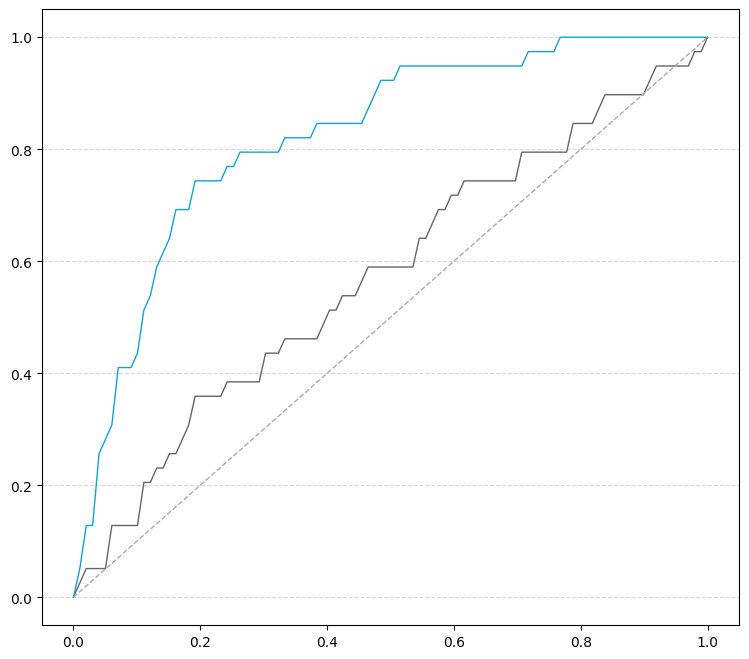

In [15]:
lw = 1

color_r, color_g, color_b, color_k = "crimson", "darkgreen", "darkblue", "black"

plt.figure(figsize=(9, 8))

plt.plot(mean_fpr, stroke_pp.p_tprs, linestyle="-", lw=lw, alpha=1, color="#656566")
plt.plot(mean_fpr, stroke_pp.pp_tprs, linestyle="-", lw=lw, alpha=1, color="#11a2d6")

red_patch = mpatches.Patch(
    color="#656565",
    label="Preoperative factors\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(pre_auroc, 0.47927036, 0.67089868)
)
green_patch = mpatches.Patch(
    color="#de9145",
    label="Intraoperative factors\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(intra_auroc, 0.69396359, 0.8361134)
)
blue_patch = mpatches.Patch(
    color="#11a2d6",
    label="Integrated (preoperative factors and intraoperative factors)\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(post_auroc, 0.76015098, 0.88291065))

delong_patch = mpatches.Patch(
    color="white",
    label="\nDeLong's test\nPre vs Intra  Z={:.3f}  P={:.3f}\nPre vs Integrated  Z={:.3f}  P={:.3f}\nIntra vs Integrated  Z={:.3f}  P={:.3f}".format(p_i_delong_z, p_i_delong_p, p_pp_delong_z, p_pp_delong_p, i_pp_delong_z, i_pp_delong_p)
)

plt.plot([0, 1], [0, 1], linestyle="--", lw=lw, color="#ababab")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True, axis="y", alpha=0.5, linestyle="dashed")
plt.show()

In [30]:

mean_fpr = np.linspace(0, 1, 100)
integ_fpr = [0,0.00248756218905473,0.00497512437810945,0.00746268656716418,0.0099502487562189,0.0124378109452736,0.0124378109452736,0.0124378109452736,0.0124378109452736,0.0199004975124378,0.0223880597014925,0.0248756218905473,0.027363184079602,0.0298507462686567,0.0323383084577114,0.0348258706467662,0.0373134328358209,0.0398009950248756,0.0422885572139304,0.0447761194029851,0.0472636815920398,0.0497512437810945,0.0522388059701493,0.054726368159204,0.0597014925373134,0.0671641791044776,0.0671641791044776,0.0696517412935323,0.0721393034825871,0.0746268656716418,0.0771144278606965,0.0796019900497512,0.082089552238806,0.082089552238806,0.0845771144278607,0.0895522388059701,0.0920398009950249,0.0945273631840796,0.0970149253731343,0.0995024875621891,0.101990049751244,0.104477611940299,0.106965174129353,0.109452736318408,0.111940298507463,0.114427860696517,0.116915422885572,0.119402985074627,0.121890547263682,0.124378109452736,0.126865671641791,0.131840796019901,0.141791044776119,0.144278606965174,0.146766169154229,0.149253731343284,0.151741293532338,0.154228855721393,0.156716417910448,0.159203980099502,0.161691542288557,0.166666666666667,0.169154228855721,0.171641791044776,0.174129353233831,0.176616915422886,0.17910447761194,0.181592039800995,0.18407960199005,0.186567164179104,0.189054726368159,0.191542288557214,0.194029850746269,0.196517412935323,0.196517412935323,0.199004975124378,0.201492537313433,0.203980099502488,0.206467661691542,0.208955223880597,0.211442786069652,0.213930348258706,0.216417910447761,0.218905472636816,0.221393034825871,0.228855721393035,0.236318407960199,0.238805970149254,0.241293532338308,0.243781094527363,0.246268656716418,0.248756218905473,0.251243781094527,0.253731343283582,0.256218905472637,0.258706467661692,0.261194029850746,0.263681592039801,0.266169154228856,0.26865671641791,0.271144278606965,0.27363184079602,0.276119402985075,0.278606965174129,0.281094527363184,0.283582089552239,0.286069651741294,0.288557213930348,0.291044776119403,0.293532338308458,0.296019900497512,0.298507462686567,0.300995024875622,0.305970149253731,0.308457711442786,0.310945273631841,0.313432835820896,0.31592039800995,0.318407960199005,0.32089552238806,0.323383084577114,0.325870646766169,0.328358208955224,0.330845771144279,0.333333333333333,0.335820895522388,0.340796019900498,0.343283582089552,0.345771144278607,0.348258706467662,0.350746268656716,0.355721393034826,0.358208955223881,0.360696517412935,0.36318407960199,0.365671641791045,0.3681592039801,0.370646766169154,0.373134328358209,0.375621890547264,0.378109452736318,0.380597014925373,0.383084577114428,0.385572139303483,0.385572139303483,0.388059701492537,0.390547263681592,0.393034825870647,0.395522388059701,0.398009950248756,0.400497512437811,0.402985074626866,0.40547263681592,0.407960199004975,0.41044776119403,0.412935323383085,0.415422885572139,0.417910447761194,0.420398009950249,0.422885572139304,0.425373134328358,0.427860696517413,0.430348258706468,0.432835820895522,0.435323383084577,0.437810945273632,0.440298507462687,0.442786069651741,0.445273631840796,0.447761194029851,0.450248756218905,0.45273631840796,0.455223880597015,0.45771144278607,0.460199004975124,0.462686567164179,0.465174129353234,0.467661691542289,0.470149253731343,0.472636815920398,0.472636815920398,0.475124378109453,0.477611940298507,0.480099502487562,0.482587064676617,0.485074626865672,0.487562189054726,0.490049751243781,0.492537313432836,0.495024875621891,0.497512437810945,0.5,0.504975124378109,0.507462686567164,0.509950248756219,0.512437810945274,0.514925373134328,0.517412935323383,0.519900497512438,0.522388059701492,0.524875621890547,0.527363184079602,0.529850746268657,0.532338308457711,0.534825870646766,0.537313432835821,0.539800995024876,0.54228855721393,0.544776119402985,0.54726368159204,0.54726368159204,0.549751243781095,0.552238805970149,0.554726368159204,0.557213930348259,0.559701492537313,0.562189054726368,0.562189054726368,0.564676616915423,0.567164179104478,0.569651741293532,0.572139303482587,0.574626865671642,0.577114427860697,0.579601990049751,0.582089552238806,0.584577114427861,0.587064676616915,0.58955223880597,0.592039800995025,0.59452736318408,0.597014925373134,0.599502487562189,0.601990049751244,0.604477611940298,0.606965174129353,0.609452736318408,0.611940298507463,0.614427860696517,0.616915422885572,0.619402985074627,0.621890547263682,0.624378109452736,0.626865671641791,0.629353233830846,0.6318407960199,0.634328358208955,0.63681592039801,0.639303482587065,0.641791044776119,0.644278606965174,0.646766169154229,0.649253731343284,0.651741293532338,0.654228855721393,0.656716417910448,0.659203980099503,0.661691542288557,0.664179104477612,0.666666666666667,0.669154228855721,0.671641791044776,0.674129353233831,0.676616915422886,0.67910447761194,0.681592039800995,0.68407960199005,0.686567164179104,0.689054726368159,0.691542288557214,0.694029850746269,0.696517412935323,0.699004975124378,0.701492537313433,0.703980099502488,0.706467661691542,0.708955223880597,0.711442786069652,0.713930348258706,0.716417910447761,0.718905472636816,0.721393034825871,0.723880597014925,0.72636815920398,0.728855721393035,0.73134328358209,0.733830845771144,0.736318407960199,0.738805970149254,0.741293532338308,0.743781094527363,0.746268656716418,0.748756218905473,0.751243781094527,0.753731343283582,0.756218905472637,0.758706467661692,0.761194029850746,0.763681592039801,0.766169154228856,0.76865671641791,0.771144278606965,0.77363184079602,0.776119402985075,0.778606965174129,0.781094527363184,0.783582089552239,0.786069651741294,0.788557213930348,0.791044776119403,0.793532338308458,0.796019900497512,0.798507462686567,0.800995024875622,0.803482587064677,0.805970149253731,0.808457711442786,0.810945273631841,0.813432835820896,0.81592039800995,0.818407960199005,0.82089552238806,0.823383084577114,0.825870646766169,0.828358208955224,0.830845771144279,0.833333333333333,0.835820895522388,0.838308457711443,0.840796019900497,0.843283582089552,0.845771144278607,0.848258706467662,0.850746268656716,0.853233830845771,0.855721393034826,0.858208955223881,0.860696517412935,0.86318407960199,0.865671641791045,0.8681592039801,0.870646766169154,0.873134328358209,0.875621890547264,0.878109452736318,0.880597014925373,0.883084577114428,0.885572139303483,0.888059701492537,0.890547263681592,0.893034825870647,0.895522388059702,0.898009950248756,0.900497512437811,0.902985074626866,0.90547263681592,0.907960199004975,0.91044776119403,0.912935323383085,0.915422885572139,0.917910447761194,0.920398009950249,0.922885572139303,0.925373134328358,0.927860696517413,0.930348258706468,0.935323383084577,0.937810945273632,0.940298507462687,0.942786069651741,0.945273631840796,0.947761194029851,0.950248756218905,0.95273631840796,0.955223880597015,0.95771144278607,0.960199004975124,0.962686567164179,0.965174129353234,0.967661691542289,0.970149253731343,0.972636815920398,0.975124378109453,0.977611940298508,0.980099502487562,0.982587064676617,0.985074626865672,0.987562189054726,0.990049751243781,0.992537313432836,0.995024875621891,0.997512437810945,1]
integ_tpr = [0,0,0,0,0,0,0.0909090909090909,0.181818181818182,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.272727272727273,0.363636363636364,0.363636363636364,0.363636363636364,0.363636363636364,0.363636363636364,0.363636363636364,0.363636363636364,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.454545454545455,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.545454545454545,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.636363636363636,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.727272727272727,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.818181818181818,0.909090909090909,0.909090909090909,0.909090909090909,0.909090909090909,0.909090909090909,0.909090909090909,0.909090909090909,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

chads2_fpr = [0,0.00497512437810945,0.0497512437810945,0.124378109452736,0.328358208955224,0.579601990049751,1]
chads2_tpr = [0,0,0.0909090909090909,0.363636363636364,0.727272727272727,0.818181818181818,1]
chads2vasc_fpr = [0,0.00248756218905473,0.0223880597014925,0.0721393034825871,0.17910447761194,0.340796019900498,0.562189054726368,0.898009950248756,1]
chads2vasc_tpr = [0,0,0.0909090909090909,0.181818181818182,0.363636363636364,0.545454545454545,0.818181818181818,1,1]
r2chads2_fpr = [0,0.0124378109452736,0.0373134328358209,0.111940298507463,0.191542288557214,0.383084577114428,0.609452736318408,1]
r2chads2_tpr = [0,0,0,0.0909090909090909,0.363636363636364,0.818181818181818,0.909090909090909,1]
rcri_fpr = [0,0.00248756218905473,0.00746268656716418,0.082089552238806,0.676616915422886,1]
rcri_tpr = [0,0,0,0,0.727272727272727,1]

integ_tprs = np.interp(mean_fpr, integ_fpr, integ_tpr)
integ_tprs[0], integ_tprs[-1] = 0.0, 1.0
chads2_tprs = np.interp(mean_fpr, chads2_fpr, chads2_tpr)
chads2_tprs[0], chads2_tprs[-1] = 0.0, 1.0
chads2vasc_tprs = np.interp(mean_fpr, chads2vasc_fpr, chads2vasc_tpr)
chads2vasc_tprs[0], chads2vasc_tprs[-1] = 0.0, 1.0
r2chads2_tprs = np.interp(mean_fpr, r2chads2_fpr, r2chads2_tpr)
r2chads2_tprs[0], r2chads2_tprs[-1] = 0.0, 1.0
rcri_tprs = np.interp(mean_fpr, rcri_fpr, rcri_tpr)
rcri_tprs[0], rcri_tprs[-1] = 0.0, 1.0

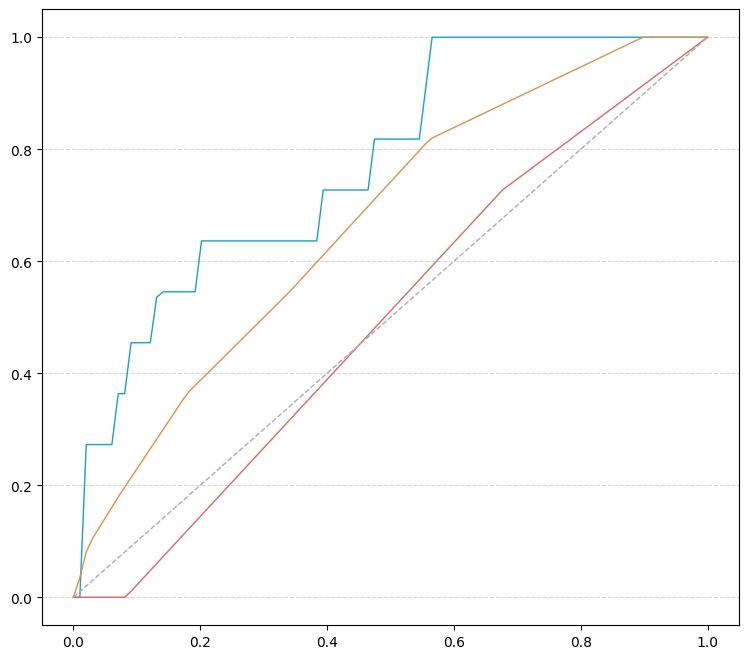

In [42]:
lw = 1

color_r, color_g, color_b, color_k = "crimson", "darkgreen", "darkblue", "black"

plt.figure(figsize=(9, 8))

plt.plot(mean_fpr, integ_tprs, linestyle="-", lw=lw, alpha=1, color="#11a2d6")
plt.plot(mean_fpr, chads2vasc_tprs, linestyle="-", lw=lw, alpha=1, color="#de9145")
plt.plot(mean_fpr, rcri_tprs, linestyle="-", lw=lw, alpha=1, color="#de6566")

red_patch = mpatches.Patch(
    color="#656565",
    label="Preoperative factors\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(pre_auroc, 0.47927036, 0.67089868)
)
green_patch = mpatches.Patch(
    color="#de9145",
    label="Intraoperative factors\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(intra_auroc, 0.69396359, 0.8361134)
)
blue_patch = mpatches.Patch(
    color="#11a2d6",
    label="Integrated (preoperative factors and intraoperative factors)\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(post_auroc, 0.76015098, 0.88291065))

delong_patch = mpatches.Patch(
    color="white",
    label="\nDeLong's test\nPre vs Intra  Z={:.3f}  P={:.3f}\nPre vs Integrated  Z={:.3f}  P={:.3f}\nIntra vs Integrated  Z={:.3f}  P={:.3f}".format(p_i_delong_z, p_i_delong_p, p_pp_delong_z, p_pp_delong_p, i_pp_delong_z, i_pp_delong_p)
)

plt.plot([0, 1], [0, 1], linestyle="--", lw=lw, color="#ababab")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True, axis="y", alpha=0.5, linestyle="dashed")
plt.show()

0.1110 0.0484 0.0179


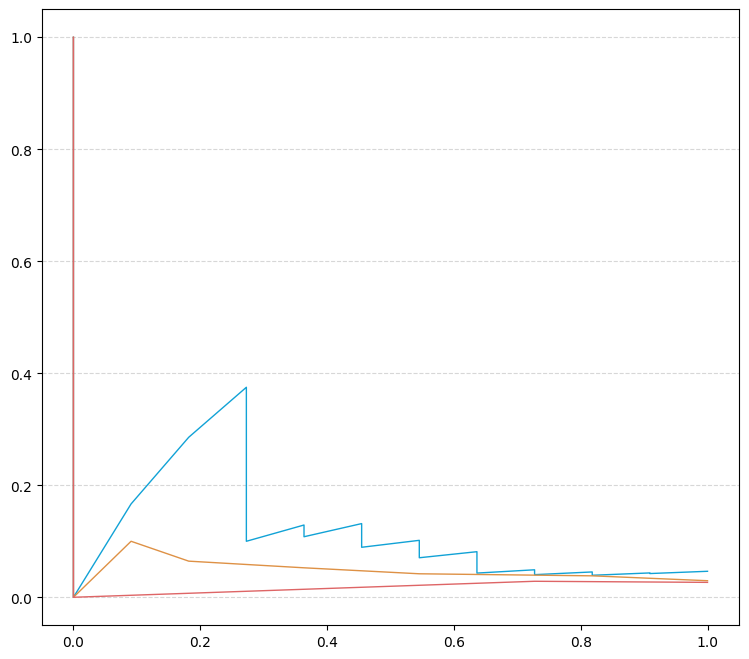

In [27]:

mean_fpr = np.linspace(0, 1, 100)
integ_prob = [0.3340800286669850,0.4816880341880340,0.58,0.7762063492063490,0.6400485347985350,0.5064249615119180,0.5024566544566550,0.5018028083028080,0.5513333333333330,0.6092008547008550,0.5611764705882350,0.42241452991453000,0.4019026251526250,0.48987581699346400,0.5797777777777780,0.6147777777777780,0.5115980384349950,0.4662094017094020,0.6316190476190480,0.46321769733534400,0.49306812468577200,0.6028253968253970,0.5477955182072830,0.5114636752136750,0.4233070818070820,0.45742194492066600,0.5227253278122840,0.7777777777777780,0.5502362996480640,0.7512063492063490,0.711059829059829,0.645,0.5397777777777780,0.5156023127199600,0.5181923076923080,0.5420036630036630,0.5213968253968250,0.5515891330891330,0.6031746031746030,0.6463968253968260,0.6610277777777780,0.6660277777777780,0.41082519852980200,0.42417923579688300,0.433469474969475,0.5991190476190480,0.6347777777777780,0.48326043237808000,0.504179235796883,0.5130980392156860,0.48528540903540900,0.4955555555555560,0.4387717797263830,0.38086635345331,0.632102564102564,0.5259869281045750,0.5684753645047760,0.5611111111111110,0.4418113553113550,0.39940145801910500,0.5062091503267980,0.671059829059829,0.4927301587301590,0.5197301587301590,0.5260335775335780,0.447892551892552,0.46787581699346400,0.5897777777777780,0.5166190476190480,0.5433049981419550,0.5465891330891330,0.4986129964806440,0.42241452991453000,0.6111111111111110,0.4710579975579980,0.6597777777777780,0.5504993894993900,0.571525641025641,0.5240595776772250,0.5763968253968260,0.46473479135243800,0.5504481074481080,0.6108888888888890,0.4884527400703870,0.6190085470085470,0.5849700854700850,0.4814957264957270,0.5233968253968250,0.49062759462759500,0.4456282582152150,0.5627656036773680,0.59,0.5202728937728940,0.4269710910005030,0.5818159879336350,0.48081990231990200,0.48046500316960700,0.6405641025641030,0.6097777777777780,0.5465238626108190,0.6397777777777780,0.6317777777777780,0.6871065862242330,0.5660277777777780,0.49639682539682500,0.49497863247863200,0.6497777777777780,0.4099689175558740,0.6497777777777780,0.4627002442002440,0.5697777777777780,0.6206275946275950,0.5830470085470090,0.4880980392156860,0.45149572649572700,0.4782604323780800,0.5616123680241330,0.46821769733534400,0.47081990231990200,0.5136190476190480,0.441525641025641,0.5441520677390240,0.4729679487179490,0.550534188034188,0.47306812468577200,0.49178144078144100,0.6015891330891330,0.5731337355455000,0.59,0.5597777777777780,0.6197777777777780,0.560063492063492,0.48149572649572700,0.6011746031746030,0.47855652517417200,0.5365891330891330,0.40341000502765200,0.4817179487179490,0.4414112252481820,0.5278758169934640,0.6797777777777780,0.6113333333333330,0.5885824534942180,0.5078758169934640,0.5015891330891330,0.4709700854700860,0.5411764705882350,0.4569988320857890,0.5788299755799760,0.5728758169934640,0.6197777777777780,0.6013333333333330,0.45879462041226800,0.4580681246857720,0.4652557997558000,0.5411111111111110,0.5408199023199020,0.5670726495726500,0.5711111111111110,0.5176367521367520,0.6197777777777780,0.5697777777777780,0.5799679487179490,0.5959316239316240,0.715,0.4971233211233210,0.6397777777777780,0.5234529914529920,0.4891660561660560,0.4528459024635500,0.5316190476190480,0.65,0.64,0.5357478632478630,0.5430980392156860,0.463290346907994,0.56,0.6244753285929760,0.631525641025641,0.5554358974358970,0.5799700854700850,0.5897777777777780,0.5517839366515840,0.5547301587301590,0.6109542483660130,0.6316239316239320,0.7,0.4862399626517270,0.4725211161387630,0.5798721539898010,0.4989591323708970,0.5252857142857140,0.4813968253968260,0.6090753968253970,0.6547777777777780,0.5789655605832080,0.720063492063492,0.7097777777777780,0.5205293040293040,0.5584294871794870,0.4888199023199020,0.6609542483660130,0.5897777777777780,0.5963968253968260,0.492991452991453,0.5063968253968260,0.62,0.49929426129426100,0.5211452991452990,0.47270024420024400,0.5205293040293040,0.549008547008547,0.4421959706959710,0.4096416361416360,0.5073117144293620,0.5811111111111110,0.5128758169934640,0.4427002442002440,0.4430225885225890,0.6063968253968260,0.48414529914529900,0.588,0.4785172548395060,0.6239288766788770,0.4387946204122680,0.4142277167277170,0.712875816993464,0.5108021978021980,0.5777457264957270,0.44575366300366300,0.56,0.48473015873015900,0.40557243410184600,0.5013333333333330,0.4187442002442000,0.4763968253968260,0.36874791633487300,0.6090549450549450,0.6747777777777780,0.5514621848739500,0.4570171471041040,0.6587387057387060,0.7427777777777780,0.5413968253968250,0.43133333333333300,0.4180848595848600,0.5295171471041040,0.5563968253968250,0.65,0.5378758169934640,0.4835683760683760,0.4946959706959710,0.539008547008547,0.5013034188034190,0.4913034188034190,0.43750396825396800,0.4929273504273510,0.5516190476190480,0.5038675213675210,0.5107946563240680,0.5765891330891330,0.4759317129304340,0.5023504273504270,0.5211111111111110,0.6113968253968260,0.49133333333333300,0.6213968253968260,0.4813034188034190,0.5603418803418800,0.6625369891546360,0.48751256913021600,0.5045079365079370,0.495906629318394,0.40158913308913300,0.5421901709401710,0.5803418803418800,0.4864267399267400,0.39908277591973200,0.5014356452726020,0.4315891330891330,0.5046416361416360,0.4362606837606840,0.48042343526039200,0.4136944444444450,0.4848468533455750,0.6111111111111110,0.5890891330891330,0.5942531063707540,0.5047405372405370,0.6123931623931620,0.5088352187028660,0.5297335695705260,0.6300634920634920,0.5136910866910870,0.5326367521367520,0.5382136752136750,0.5084015470179150,0.4513333333333330,0.5140595776772250,0.6715424836601310,0.5023895353013,0.46161904761904800,0.4227002442002440,0.5311111111111110,0.611525641025641,0.47468437118437100,0.7097777777777780,0.4976628053674090,0.6371065862242330,0.5291258169934640,0.5616452991452990,0.4847493894993900,0.39349209940386400,0.5119261294261300,0.5851303418803420,0.38999669611434300,0.43244444444444400,0.4915271672771670,0.36830708180708200,0.5320912698412700,0.4934722222222220,0.4614322703440350,0.5078730158730160,0.62,0.4375079365079370,0.46658913308913300,0.5303758169934640,0.5624758852258850,0.593960927960928,0.49335409035409000,0.4920922386791950,0.6052557997558000,0.4262399626517270,0.3944884364002010,0.6151502190619840,0.46934620693316400,0.4010421245421250,0.5942222222222220,0.48143162393162400,0.47115689865689900,0.46287118437118400,0.5891111111111110,0.5406275946275950,0.6491938870308440,0.6478758169934640,0.4721279537456010,0.47415323565323600,0.4360354449472100,0.6497777777777780,0.5527570738440300,0.46163558422254100,0.4209700854700860,0.46494632981397700,0.4551532356532360,0.48538562091503300,0.5067141233304920,0.489465811965812,0.43705982905982900,0.5134673382173380,0.6302857142857140,0.6324286073403720,0.5511111111111110,0.40800402212166900,0.45210256410256400,0.7097777777777780,0.5198711843711840,0.3934053724053720,0.5308199023199020,0.4354038992408560,0.4850091934209580,0.45600615887380600,0.5409826546003020,0.5324444444444450,0.6445266106442580,0.4915891330891330,0.6152857142857140,0.6833333333333340,0.5952857142857140,0.42381990231990200,0.4712399626517270,0.440074534942182,0.49458547008547,0.6197777777777780,0.59,0.4969310134310140,0.5268113553113550,0.5841025641025640,0.6393931623931630,0.5508498168498170,0.4432130647130650,0.5547301587301590,0.6042445952740070,0.6493800904977380,0.4244219090088660,0.5869252136752140,0.5230980392156860,0.4940595776772250,0.45128057811753500,0.5442927881297450,0.4284731910601480,0.5219310134310130,0.5954053724053720,0.5905018853695320,0.5429679487179490,0.62,0.525884004884005,0.4736322272498740,0.39241452991453000,0.44486385836385800,0.5068828908374950,0.30413619472315100,0.5629951690821260,0.46481963298139800]
vasc_prob = [1 , 3 , 4 , 0 , 4 , 1 , 1 , 2 , 7 , 3 , 0 , 3 , 1 , 3 , 0 , 3 , 2 , 2 , 1 , 0 , 4 , 4 , 1 , 1 , 2 , 1 , 3 , 1 , 2 , 2 , 6 , 1 , 3 , 1 , 1 , 6 , 2 , 3 , 2 , 2 , 0 , 0 , 5 , 1 , 1 , 3 , 0 , 1 , 1 , 2 , 1 , 1 , 1 , 1 , 4 , 3 , 5 , 5 , 5 , 1 , 2 , 3 , 1 , 0 , 1 , 1 , 1 , 6 , 2 , 2 , 2 , 1 , 1 , 2 , 1 , 2 , 3 , 4 , 3 , 2 , 1 , 1 , 3 , 1 , 4 , 1 , 1 , 1 , 0 , 1 , 1 , 4 , 5 , 0 , 3 , 1 , 0 , 5 , 1 , 1 , 2 , 4 , 2 , 2 , 3 , 2 , 3 , 2 , 1 , 3 , 2 , 3 , 3 , 0 , 3 , 0 , 2 , 1 , 0 , 1 , 3 , 4 , 5 , 2 , 2 , 3 , 2 , 3 , 5 , 5 , 2 , 4 , 4 , 1 , 0 , 4 , 3 , 6 , 4 , 1 , 5 , 4 , 4 , 4 , 1 , 3 , 1 , 2 , 3 , 0 , 4 , 1 , 3 , 0 , 2 , 1 , 2 , 3 , 2 , 4 , 3 , 4 , 1 , 3 , 2 , 1 , 5 , 3 , 0 , 1 , 1 , 1 , 3 , 1 , 3 , 2 , 4 , 5 , 2 , 2 , 2 , 4 , 4 , 4 , 1 , 1 , 1 , 0 , 2 , 1 , 2 , 3 , 3 , 2 , 2 , 3 , 2 , 4 , 0 , 1 , 2 , 4 , 1 , 1 , 3 , 2 , 2 , 2 , 4 , 1 , 0 , 1 , 1 , 2 , 6 , 4 , 2 , 1 , 1 , 4 , 2 , 1 , 1 , 3 , 2 , 3 , 3 , 0 , 3 , 1 , 1 , 5 , 2 , 1 , 1 , 2 , 0 , 5 , 5 , 1 , 3 , 2 , 1 , 4 , 4 , 1 , 1 , 3 , 3 , 0 , 4 , 3 , 4 , 1 , 1 , 2 , 1 , 2 , 3 , 2 , 2 , 1 , 2 , 2 , 2 , 2 , 4 , 2 , 4 , 0 , 4 , 1 , 1 , 1 , 1 , 2 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 2 , 1 , 3 , 1 , 2 , 3 , 5 , 1 , 2 , 2 , 2 , 1 , 4 , 2 , 1 , 1 , 3 , 3 , 3 , 2 , 2 , 0 , 4 , 2 , 2 , 1 , 4 , 1 , 1 , 2 , 1 , 0 , 0 , 3 , 1 , 2 , 5 , 4 , 1 , 1 , 2 , 1 , 1 , 0 , 2 , 2 , 1 , 4 , 3 , 2 , 2 , 2 , 3 , 1 , 3 , 0 , 6 , 0 , 0 , 1 , 1 , 3 , 0 , 1 , 0 , 1 , 1 , 2 , 2 , 3 , 2 , 3 , 1 , 4 , 3 , 0 , 1 , 1 , 2 , 1 , 1 , 1 , 2 , 2 , 0 , 1 , 5 , 1 , 4 , 6 , 2 , 1 , 1 , 3 , 1 , 6 , 5 , 1 , 5 , 6 , 3 , 1 , 1 , 3 , 3 , 4 , 3 , 1 , 1 , 1 , 2 , 0 , 1 , 1 , 1 , 2 , 2 , 5 , 0 , 2 , 4 , 0 , 1 , 3 , 1 , 3]
rcri_prob = [1 , 0 , 0 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 1 , 1 , 2 , 1 , 0 , 1 , 1 , 0 , 1 , 1 , 0 , 0 , 0 , 1 , 0 , 1 , 0 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 0 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 2 , 0 , 1 , 2 , 1 , 2 , 0 , 0 , 1 , 0 , 0 , 1 , 1 , 0 , 1 , 1 , 0 , 1 , 0 , 0 , 3 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 0 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 0 , 0 , 1 , 1 , 1 , 2 , 0 , 0 , 0 , 1 , 0 , 1 , 1 , 0 , 1 , 1 , 0 , 2 , 2 , 0 , 0 , 0 , 1 , 0 , 1 , 1 , 2 , 0 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 1 , 0 , 1 , 1 , 2 , 1 , 1 , 0 , 0 , 0 , 0 , 1 , 2 , 0 , 1 , 0 , 1 , 2 , 0 , 1 , 1 , 1 , 1 , 2 , 0 , 1 , 1 , 0 , 0 , 1 , 0 , 1 , 1 , 4 , 1 , 1 , 1 , 2 , 1 , 1 , 0 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 0 , 1 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 2 , 1 , 0 , 1 , 0 , 1 , 2 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 2 , 1 , 1 , 1 , 1 , 0 , 0 , 0 , 1 , 1 , 2 , 1 , 1 , 2 , 0 , 1 , 0 , 0 , 1 , 2 , 1 , 1 , 0 , 0 , 0 , 0 , 0 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 0 , 2 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 0 , 1 , 2 , 1 , 0 , 0 , 0 , 0 , 1 , 2 , 1 , 2 , 1 , 2 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 2 , 1 , 0 , 1 , 0 , 2 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 0 , 2 , 1 , 1 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 1 , 1 , 0 , 0 , 1 , 0 , 1 , 1 , 0 , 0 , 0 , 0 , 1 , 2 , 0 , 0 , 1 , 0 , 1 , 1 , 1 , 2 , 1 , 1 , 0 , 0 , 1 , 1 , 1 , 2 , 1 , 1 , 1 , 1 , 0 , 1 , 0 , 1 , 3 , 1 , 1 , 0 , 1 , 1 , 1 , 1 , 1 , 1 , 1 , 0 , 0 , 0 , 1 , 1 , 1 , 0 , 0 , 1 , 0 , 1 , 0 , 0 , 1 , 1 , 1 , 0]

label_is_stroke = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]

from sklearn.metrics import precision_recall_curve

int_pre, int_rec, _ = precision_recall_curve(label_is_stroke, integ_prob)
int_auprc = auc(int_rec, int_pre)
vasc_pre, vasc_rec, _ = precision_recall_curve(label_is_stroke, vasc_prob)
vasc_auprc = auc(vasc_rec, vasc_pre)
rcri_pre, rcri_rec, _ = precision_recall_curve(label_is_stroke, rcri_prob)
rcri_auprc = auc(rcri_rec, rcri_pre)



print("{:.4f} {:.4f} {:.4f}".format(int_auprc, vasc_auprc, rcri_auprc))

lw = 1

color_r, color_g, color_b, color_k = "crimson", "darkgreen", "darkblue", "black"

plt.figure(figsize=(9, 8))

plt.plot(int_rec, int_pre, linestyle="-", lw=lw, alpha=1, color="#11a2d6")
plt.plot(vasc_rec, vasc_pre, linestyle="-", lw=lw, alpha=1, color="#de9145")
plt.plot(rcri_rec, rcri_pre, linestyle="-", lw=lw, alpha=1, color="#de6566")

red_patch = mpatches.Patch(
    color="#656565",
    label="Preoperative factors\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(int_auprc, 0.47927036, 0.67089868)
)
green_patch = mpatches.Patch(
    color="#de9145",
    label="Intraoperative factors\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(vasc_auprc, 0.69396359, 0.8361134)
)
blue_patch = mpatches.Patch(
    color="#11a2d6",
    label="Integrated (preoperative factors and intraoperative factors)\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(rcri_auprc, 0.76015098, 0.88291065)
)


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True, axis="y", alpha=0.5, linestyle="dashed")
plt.show()

In [16]:
np.array(label_is_stroke).reshape(-1)

(413,)

In [12]:
class CoreUtils():
    def __init__(self):
        pass

    def check_label_ratio(self, df, column):
        neg, pos = np.bincount(df[column])
        total = neg + pos

        print("{}\n    Total: {}\n    Nagatives: {}\n    Positives: {} ({:.2f}% of dataframe)\n".format(
            column, total, neg, pos, (pos / total * 100)
        ))

    def check_valid_model(self, model, X_test, y_test, t_sen, t_spe, verbose=False):
        y_pred = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen = tp / (tp + fn)
        spe = tn / (tn + fp)

        if verbose:
            print("Sensitivity: {:.3f}, Specificity: {:.3f}".format(sen, spe))

        if (sen >= t_sen) & (spe >= t_spe):
            return True
        else:
            return False


    def compute_model_performance(self, model, X_test, y_test, youden=False):
        y_pred = model.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auroc = auc(fpr, tpr)

        if youden:
            J = tpr - fpr
            ix = np.argmax(J)
            best_threshold = thresholds[ix]

            y_pred = (y_pred >= best_threshold).astype(int)
        else:
            y_pred = (y_pred >= 0.5).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        acc = (tp + tn) / (tp + fn + fp + tn)
        sen = tp / (tp + fn)
        spe = tn / (tn + fp)
        pre = tp / (tp + fp)
        f1 = (2 * pre * sen) / (pre + sen)

        npv = tn / (tn + fn)
        odd_ratio = (tp * tn) / (fp * fn)

        if youden:
            return pd.DataFrame([best_threshold, auroc, acc, pre, sen, spe, f1, npv, odd_ratio]).T
        else:
            return pd.DataFrame([auroc, acc, pre, sen, spe, f1, npv, odd_ratio]).T


    def compute_model_tprs(self, model, X_test, y_test):
        mean_fpr = np.linspace(0, 1, 100)

        train_tprs, test_tprs = [], []

        y_test_pred = model.predict_proba(X_test)[:, 1]

        test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred)

        test_auroc = auc(test_fpr, test_tpr)

        test_tprs.append(np.interp(mean_fpr, test_fpr, test_tpr))
        test_tprs[-1][0] = 0.0
        test_tprs = np.mean(test_tprs, axis=0)

        return pd.DataFrame([test_tprs, [test_auroc]]).T


    def compute_shap_values(self, model, X_test, mode):
        feature_names = X_test.columns

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        if mode == "rf" or mode == "lgb":
            model_shap = pd.DataFrame(
                list(
                    zip(
                        feature_names, np.abs(pd.DataFrame(shap_values[1], columns=feature_names).values).mean(0)
                    )
                ),
                columns=["columns", "shap_values"]
            )
        elif mode == "xgb":
            model_shap = pd.DataFrame(
                list(
                    zip(
                        feature_names, np.abs(pd.DataFrame(shap_values, columns=feature_names).values).mean(0)
                    )
                ),
                columns=["columns", "shap_values"]
            )

        return model_shap.sort_values(by=["shap_values"], ascending=False)

    def compute_youden_index(self, model, X_test, y_test):
        y_pred = model.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auroc = auc(fpr, tpr)

        J = tpr - fpr
        ix = np.argmax(J)
        best_threshold = thresholds[ix]

        y_pred = (y_pred >= best_threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        sen = tp / (tp + fn)
        spe = tn / (tn + fp)

        ppv = tp / (tp + fp)
        npv = tn / (tn + tn)
        print("ppv={:.3f} npv={:.3f}".format(ppv, npv))

        odd_ratio = (tp * tn) / (fp * fn)
        print("odd_ratio={:.3f}".format(odd_ratio))

        mean_fpr = np.linspace(0, 1, 100)

        tprs = []
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        tprs = np.mean(tprs, axis=0)

        return tprs, fpr, tpr, auroc, best_threshold, ix, sen, spe

In [20]:
class BRMHStroke():
    def __init__(self, kfold=True, model_save=False, debug=False, shap=False):
        self.cores = CoreUtils()

        self.PATH_DATASET = None
        self.PATH_SAVE = None

        self.WITH_KFOLD = kfold
        self.WITH_SAVE = model_save
        self.WITH_MODEL_DEBUG = debug
        self.WITH_SHAP = shap

        self.c_pre, c_post = [], []
        self.c_hours = []

        self.df = None

        self.df_ttest_tp = None
        self.df_ttest_mean = None
        self.df_ttest_std = None

        self.df_train = None
        self.df_test = None
        self.X_train, self.y_train = None, None
        self.X_test, self.y_test = None, None

        self.rf_summary, self.rf_tprs, self.rf_summary_youden, self.rf_shap = [], [], [], []
        self.xgb_summary, self.xgb_tprs, self.xgb_summary_youden, self.xgb_shap = [], [], [], []
        self.lgb_summary, self.lgb_tprs, self.lgb_summary_youden, self.lgb_shap = [], [], [], []

        self.pre_tprs, self.post_tprs = [], []


    def set_path(self, path_dataset, path_save):
        self.PATH_DATASET = path_dataset
        self.PATH_SAVE = path_save


    def load_dataset(self):
        try:
            df = pd.read_csv(self.PATH_DATASET, sep=",")
        except:
            print("Error to open file")
            raise
        print(df.shape)

        df["sum_rbc_my"] = df["sum_rbc_my"].fillna(0)
        df["sum_tf"] = df["sum_ffp"] + df["sum_plt"] + df["sum_cryo"] + df["sum_rbc_my"]
        df["sum_io"] = df["sum_fluid"] - (df["sum_uo"] + df["sum_ebl"])

        self.df = df.copy()


    def drop_exclusion(self):
        df = self.df.copy()

        ## exclusion age
        query = "age < 18"
        df = df.drop(index=df.query(query).index)
        print("ex a >> ", df.shape)

        ## exclusion weight
        query = "weight < 30 | weight >= 140"
        df = df.drop(index=df.query(query).index)
        print("ex w >> ", df.shape)

        ## exclusion height
        query = "height < 135 | height >= 200"
        df = df.drop(index=df.query(query).index)
        print("ex h >> ", df.shape)

        ## exclusion op duration
        query = "opdur_cal_sm <= 20"
        df = df.drop(index=df.query(query).index)
        print("ex o >> ", df.shape)

        self.df = df.copy()


    def set_features(self):
        df = self.df.copy()
        df = df.rename(columns={"opdur_cal_sm": "opdur_cal_sm2"})  ## bugfix

        self.c_basic = [
            "no", "ptno", "serialno", "opname"
        ]
        self.c_pre = [
            "age", "sex",
            "height", "weight", "bmi",
            "preop_asa", "preop_emop",
            "preop_htn", "preop_dm", "preop_cva", "preop_asthma", "preop_copd",
            "preop_liverds", "preop_kidneyds", "preop_tb", "preop_hb_my", "preop_plt_sm",
            "preop_cr_sm", "preop_na", "preop_alb", "preop_bun", "preop_k_sm",
            "preop_pt", "preop_ptt_sm", "preop_glucose_sm", "preop_gpt_sm", "preop_got",
            "preop_egfr"
        ]
        self.c_post = [
            "opdur_cal_sm2", "andur_cal_my",
            "sum_uo", "sum_ebl", "sum_crystalloid", "sum_colloid", "sum_fluid", "sum_rbc_my",
            "sum_ffp", "sum_plt", "sum_cryo", "sum_tf", "sum_io",

            "SBP_below100", "SBP_below95", "SBP_below90", "SBP_below85", "SBP_below80",
            "SBP_below75", "SBP_below70", "SBP_below65", "SBP_below60", "SBP_below55",
            "SBP_below50", "SBP_mean", "SBP_std",

            "DBP_below70", "DBP_below65", "DBP_below60", "DBP_below55", "DBP_below50",
            "DBP_below45", "DBP_below40", "DBP_below35", "DBP_below30", "DBP_below25",
            "DBP_below20", "DBP_mean", "DBP_std",

            "SPO2_below95",
            "SPO2_mean", "SPO2_std",

            "HR_above100", "HR_above105", "HR_above110", "HR_above115", "HR_above120",
            "HR_above125", "HR_above130", "HR_above135", "HR_above140", "HR_above145",
            "HR_above150", "HR_below60", "HR_below55", "HR_below50", "HR_below45",
            "HR_below40", "HR_below35", "HR_mean", "HR_std",
        ]


        df = df[self.c_basic + self.c_pre + self.c_post + ["is_stroke"]]

        self.df = df.copy()


    def fill_features(self, mode):
        df = self.df.copy()

        print("fill features original >> ", df.shape)
        self.cores.check_label_ratio(df, "is_stroke")



        for column in df.columns:
            try:
                df[column] = df[column].astype(float)
            except:
                print(column)

        df = df.dropna()
        print("drop >> ", df.shape)

        if mode == "pp":
            df = df[self.c_pre + self.c_post + ["is_stroke"]]
            #             df = df[self.c_pre + self.c_hours + ["is_stroke"]]
            print(df.shape)
        elif mode == "i":
            df = df[self.c_post + ["is_stroke"]]
            print(df.shape)
        elif mode == "p":
            df = df[self.c_pre + ["is_stroke"]]
            print(df.shape)
        elif mode == "custom":
            df = df[self.c_basic + self.c_pre + self.c_post + ["is_stroke"]]
            print(df.shape)
        else:
            print("??")
            raise



        self.df = df.copy()


    def compute_ttest(self):
        df = self.df.copy()

        query = "is_stroke == 0"
        df_control = df.query(query).drop(columns=["is_stroke"]).reset_index(drop=True)
        query = "is_stroke == 1"
        df_target = df.query(query).drop(columns=["is_stroke"]).reset_index(drop=True)

        li = []
        for column in df_control.columns:
            ret = stats.ttest_ind(df_control[column], df_target[column], equal_var=True)
            li.append([column, "{:.5f}".format(ret[0]), "{:.5f}".format(ret[1])])

        self.df_ttest_tp = pd.DataFrame(li, columns=["feature_name", "t_value", "p_value"])

        self.df_ttest_mean = pd.concat(
            [pd.DataFrame(np.mean(df_control), columns=["control"]),
             pd.DataFrame(np.mean(df_target), columns=["is_stroke"])],
            axis=1
        )

        self.df_ttest_std = pd.concat(
            [pd.DataFrame(np.std(df_control), columns=["control"]),
             pd.DataFrame(np.std(df_target), columns=["is_stroke"])],
            axis=1
        )


    def train_test_split(self):
        df = self.df.copy()

        self.X_test = df.drop(columns=["is_stroke"])
        self.y_test = df["is_stroke"]

        print(self.X_test.shape, self.y_test.shape)


    def forward(self, n_folds, n_epochs, n_cores, t_sen, t_spe, p_rf, p_xgb, p_lgb):
        print(datetime.datetime.now())

        df_train, df_test = self.df_train.copy(), self.df_test.copy()

        p_rf, p_xgb, p_lgb = p_rf, p_xgb, p_lgb
        while (p_rf < n_epochs) | (p_xgb < n_epochs) | (p_lgb < n_epochs):
            print(p_rf, p_xgb, p_lgb)

            rf_model = RandomForestClassifier(
                n_estimators=100,  max_depth=9,  bootstrap=False,
                criterion="gini",  max_features=None,  max_samples=None,  n_jobs=n_cores,
            )
            xgb_model = xgb.XGBClassifier(
                objective="binary:logistic",  n_estimators=100,  max_depth=9,
                verbosity=0,  booster="gbtree",  use_label_encoder=False,  tree_method="gpu_hist",
                eval_metric="auc",  n_jobs=n_cores,
            )
            lgb_model = lgb.LGBMClassifier(
                objective="binary",  n_estimators=200,  max_depth=9,
                boosting_type="gbdt",  metric="auc",  n_jobs=n_cores,
            )

            rf_tprs, xgb_tprs, lgb_tprs = [], [], []
            rf_aucs, xgb_aucs, lgb_aucs = [], [], []

            if self.WITH_KFOLD:
                folds = StratifiedKFold(n_splits=n_folds)

                for train_idx, valid_idx in folds.split(self.X_train, self.y_train):
                    X_trainset, y_trainset = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
                    X_validset, y_validset = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

                    undersampler = RandomUnderSampler(
                        replacement=True, sampling_strategy="majority",
                        random_state=np.random.RandomState()
                    )
                    X_trainset, y_trainset = undersampler.fit_resample(X_trainset, y_trainset)

                    if p_rf < n_epochs:
                        rf_model.fit(X_trainset, y_trainset)
                    if p_xgb < n_epochs:
                        xgb_model.fit(X_trainset, y_trainset)
                    if p_lgb < n_epochs:
                        lgb_model.fit(X_trainset, y_trainset)

            ## Check performance and get summaries
            if p_rf < n_epochs:
                if self.cores.check_valid_model(rf_model, self.X_test, self.y_test, t_sen-0.05, t_spe-0.05, verbose=self.WITH_MODEL_DEBUG):
                    if self.WITH_SAVE:
                        joblib.dump(rf_model, "{}_rf_ep{:02d}.pkl".format(self.PATH_SAVE, p_rf))

                    self.rf_summary.append(self.cores.compute_model_performance(rf_model, self.X_test, self.y_test))
                    self.rf_tprs.append(self.cores.compute_model_tprs(rf_model, self.X_train, self.y_train, self.X_test, self.y_test))
                    self.rf_summary_youden.append(self.cores.compute_model_performance(rf_model, self.X_test, self.y_test, youden=True))

                    if self.WITH_SHAP:
                        self.rf_shap.append(self.cores.compute_shap_values(rf_model, self.X_test, "rf"))

                    p_rf = p_rf + 1

            if p_xgb < n_epochs:
                if self.cores.check_valid_model(xgb_model, self.X_test, self.y_test, t_sen, t_spe, verbose=self.WITH_MODEL_DEBUG):
                    if self.WITH_SAVE:
                        joblib.dump(xgb_model, "{}_xgb_ep{:02d}.pkl".format(self.PATH_SAVE, p_xgb))

                    self.xgb_summary.append(self.cores.compute_model_performance(xgb_model, self.X_test, self.y_test))
                    self.xgb_tprs.append(self.cores.compute_model_tprs(xgb_model, self.X_train, self.y_train, self.X_test, self.y_test))
                    self.xgb_summary_youden.append(self.cores.compute_model_performance(xgb_model, self.X_test, self.y_test, youden=True))

                    if self.WITH_SHAP:
                        self.xgb_shap.append(self.cores.compute_shap_values(xgb_model, self.X_test, "xgb"))

                    p_xgb = p_xgb + 1

            if p_lgb < n_epochs:
                if self.cores.check_valid_model(lgb_model, self.X_test, self.y_test, t_sen, t_spe, verbose=self.WITH_MODEL_DEBUG):
                    if self.WITH_SAVE:
                        joblib.dump(lgb_model, "{}_lgb_ep{:02d}.pkl".format(self.PATH_SAVE, p_lgb))

                    self.lgb_summary.append(self.cores.compute_model_performance(lgb_model, self.X_test, self.y_test))
                    self.lgb_tprs.append(self.cores.compute_model_tprs(lgb_model, self.X_train, self.y_train, self.X_test, self.y_test))
                    self.lgb_summary_youden.append(self.cores.compute_model_performance(lgb_model, self.X_test, self.y_test, youden=True))

                    if self.WITH_SHAP:
                        self.lgb_shap.append(self.cores.compute_shap_values(lgb_model, self.X_test, "lgb"))

                    p_lgb = p_lgb + 1

        print(datetime.datetime.now())


    def recheck(self, PATH_MODEL_SAVED):
        self.rf_summary, self.rf_tprs, self.rf_summary_youden, self.rf_shap = [], [], [], []
        self.xgb_summary, self.xgb_tprs, self.xgb_summary_youden, self.xgb_shap = [], [], [], []
        self.lgb_summary, self.lgb_tprs, self.lgb_summary_youden, self.lgb_shap = [], [], [], []

        li_rf, li_xgb, li_lgb = [], [], []
        for file in glob.glob(os.path.join(PATH_MODEL_SAVED)):
            if "rf_" in file:
                li_rf.append(file)
            elif "xgb_" in file:
                li_xgb.append(file)
            elif "lgb_" in file:
                li_lgb.append(file)
            else:
                pass
        li_rf.sort(), li_xgb.sort(), li_lgb.sort()

        for file in li_rf:
            print(file)
            model = joblib.load(file)

            self.rf_summary.append(self.cores.compute_model_performance(model, self.X_test, self.y_test))
            self.rf_tprs.append(self.cores.compute_model_tprs(model, self.X_test, self.y_test))
            self.rf_summary_youden.append(self.cores.compute_model_performance(model, self.X_test, self.y_test, youden=True))

            if self.WITH_SHAP:
                self.rf_shap.append(self.cores.compute_shap_values(model, self.X_test, "rf"))
            if self.WITH_FEATURE_IMPORTANCE:
                self.rf_feature_importance.append(pd.DataFrame(np.concatenate([model.feature_names_in_.reshape(-1, 1), model.feature_importances_.reshape(-1, 1)], axis=1)))
                results = permutation_importance(model, self.X_test, self.y_test, scoring="neg_mean_squared_error")
                self.rf_permute_importance.append(pd.DataFrame(np.concatenate([model.feature_names_in_.reshape(-1, 1), results.importances_mean.reshape(-1, 1)], axis=1)))

        for file in li_xgb:
            print(file)
            model = joblib.load(file)

            self.xgb_summary.append(self.cores.compute_model_performance(model, self.X_test, self.y_test))
            self.xgb_tprs.append(self.cores.compute_model_tprs(model, self.X_test, self.y_test))
            self.xgb_summary_youden.append(self.cores.compute_model_performance(model, self.X_test, self.y_test, youden=True))

            if self.WITH_SHAP:
                self.xgb_shap.append(self.cores.compute_shap_values(model, self.X_test, "xgb"))
            if self.WITH_FEATURE_IMPORTANCE:
                self.xgb_feature_importance.append(pd.DataFrame(np.concatenate([model.feature_names_in_.reshape(-1, 1), model.feature_importances_.reshape(-1, 1)], axis=1)))
                results = permutation_importance(model, self.X_test, self.y_test, scoring="neg_mean_squared_error")
                self.xgb_permute_importance.append(pd.DataFrame(np.concatenate([model.feature_names_in_.reshape(-1, 1), results.importances_mean.reshape(-1, 1)], axis=1)))

        for file in li_lgb:
            print(file)
            model = joblib.load(file)

            self.lgb_summary.append(self.cores.compute_model_performance(model, self.X_test, self.y_test))
            self.lgb_tprs.append(self.cores.compute_model_tprs(model, self.X_test, self.y_test))
            self.lgb_summary_youden.append(self.cores.compute_model_performance(model, self.X_test, self.y_test, youden=True))

            if self.WITH_SHAP:
                self.lgb_shap.append(self.cores.compute_shap_values(model, self.X_test, "lgb"))
            if self.WITH_FEATURE_IMPORTANCE:
                self.lgb_feature_importance.append(pd.DataFrame(np.concatenate([np.array(model.feature_name_).reshape(-1, 1), model.feature_importances_.reshape(-1, 1)], axis=1)))
                results = permutation_importance(model, self.X_test, self.y_test, scoring="neg_mean_squared_error")
                self.lgb_permute_importance.append(pd.DataFrame(np.concatenate([np.array(model.feature_name_).reshape(-1, 1), results.importances_mean.reshape(-1, 1)], axis=1)))

    def plot_youden_index(self, rf_path, xgb_path, lgb_path, title):
        rf_model = joblib.load(rf_path)
        xgb_model = joblib.load(xgb_path)
        lgb_model = joblib.load(lgb_path)

        rf_tprs, rf_fpr, rf_tpr, rf_auroc, rf_thr, rf_ix, rf_sen, rf_spe = self.cores.compute_youden_index(rf_model, self.X_test, self.y_test)
        xgb_tprs, xgb_fpr, xgb_tpr, xgb_auroc, xgb_thr, xgb_ix, xgb_sen, xgb_spe = self.cores.compute_youden_index(xgb_model, self.X_test, self.y_test)
        lgb_tprs, lgb_fpr, lgb_tpr, lgb_auroc, lgb_thr, lgb_ix, lgb_sen, lgb_spe = self.cores.compute_youden_index(lgb_model, self.X_test, self.y_test)

        lw = 1

        FONT_SIZE = 10
        plt.rc("font", size=FONT_SIZE) # controls default text sizes
        plt.rc("axes", titlesize=FONT_SIZE) # fontsize of the axes title
        plt.rc("axes", labelsize=FONT_SIZE) # fontsize of the x and y labels
        plt.rc("xtick", labelsize=FONT_SIZE) # fontsize of the tick labels
        plt.rc("ytick", labelsize=FONT_SIZE) # fontsize of the tick labels
        plt.rc("legend", fontsize=FONT_SIZE) # legend fontsize
        plt.rc("figure", titlesize=FONT_SIZE) # fontsize of the figure title

        color_r, color_g, color_b = "crimson", "darkgreen", "darkblue"

        plt.figure(figsize=(7, 6))

        plt.plot(rf_fpr, rf_tpr, linestyle="-", lw=lw, alpha=1, color="k")
        plt.plot(xgb_fpr, xgb_tpr, linestyle="-", lw=lw, alpha=1, color="k")
        plt.plot(lgb_fpr, lgb_tpr, linestyle="-", lw=lw, alpha=1, color="k")

        plt.scatter(rf_fpr[rf_ix], rf_tpr[rf_ix], marker="+", s=100, lw=3, color=color_r)
        plt.scatter(xgb_fpr[xgb_ix], xgb_tpr[xgb_ix], marker="+", s=100, lw=3, color=color_g)
        plt.scatter(lgb_fpr[lgb_ix], lgb_tpr[lgb_ix], marker="+", s=100, lw=3, color=color_b)

        plt.plot([0, 1], [0, 1], linestyle="--", lw=lw, color="k")
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel("1-Specificity")
        plt.ylabel("Sensitivity")
        plt.title(title)

        red_patch = mpatches.Patch(
            color=color_r,
            label="RandomForest\nAUC={:.3f} Th={:.3f} Se={:.3f} Sp={:.3f}".format(rf_auroc, rf_thr, rf_sen, rf_spe)
        )
        green_patch = mpatches.Patch(
            color=color_g,
            label="XGBoost\nAUC={:.3f} Th={:.3f} Se={:.3f} Sp={:.3f}".format(xgb_auroc, xgb_thr, xgb_sen, xgb_spe)
        )
        blue_patch = mpatches.Patch(
            color=color_b,
            label="LightGBM\nAUC={:.3f} Th={:.3f} Se={:.3f} Sp={:.3f}".format(lgb_auroc, lgb_thr, lgb_sen, lgb_spe)
        )

        plt.legend(loc="lower right", handles=[red_patch, green_patch, blue_patch])
        plt.show()


    # AUC comparison adapted from
    # https://github.com/Netflix/vmaf/
    def compute_midrank(self, x):
        """Computes midranks.
        Args:
           x - a 1D numpy array
        Returns:
           array of midranks
        """
        J = np.argsort(x)
        Z = x[J]
        N = len(x)
        T = np.zeros(N, dtype=np.float)
        i = 0
        while i < N:
            j = i
            while j < N and Z[j] == Z[i]:
                j += 1
            T[i:j] = 0.5*(i + j - 1)
            i = j
        T2 = np.empty(N, dtype=np.float)
        # Note(kazeevn) +1 is due to Python using 0-based indexing
        # instead of 1-based in the AUC formula in the paper
        T2[J] = T + 1
        return T2


    def fastDeLong(self, predictions_sorted_transposed, label_1_count):
        """
        The fast version of DeLong's method for computing the covariance of
        unadjusted AUC.
        Args:
           predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
              sorted such as the examples with label "1" are first
        Returns:
           (AUC value, DeLong covariance)
        Reference:
         @article{sun2014fast,
           title={Fast Implementation of DeLong's Algorithm for
                  Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
           author={Xu Sun and Weichao Xu},
           journal={IEEE Signal Processing Letters},
           volume={21},
           number={11},
           pages={1389--1393},
           year={2014},
           publisher={IEEE}
         }
        """
        # Short variables are named as they are in the paper
        m = label_1_count
        n = predictions_sorted_transposed.shape[1] - m
        positive_examples = predictions_sorted_transposed[:, :m]
        negative_examples = predictions_sorted_transposed[:, m:]
        k = predictions_sorted_transposed.shape[0]

        tx = np.empty([k, m], dtype=np.float)
        ty = np.empty([k, n], dtype=np.float)
        tz = np.empty([k, m + n], dtype=np.float)
        for r in range(k):
            tx[r, :] = self.compute_midrank(positive_examples[r, :])
            ty[r, :] = self.compute_midrank(negative_examples[r, :])
            tz[r, :] = self.compute_midrank(predictions_sorted_transposed[r, :])
        aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
        v01 = (tz[:, :m] - tx[:, :]) / n
        v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
        sx = np.cov(v01)
        sy = np.cov(v10)
        delongcov = sx / m + sy / n
        return aucs, delongcov


    def calc_pvalue(self, aucs, sigma):
        """Computes log(10) of p-values.
        Args:
           aucs: 1D array of AUCs
           sigma: AUC DeLong covariances
        Returns:
           log10(pvalue)
        """
        l = np.array([[1, -1]])
        z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
        p = 2 * (1 - scipy.stats.norm.cdf(z, loc=0, scale=1))
        return z, p

    def compute_ground_truth_statistics(self, ground_truth):
        assert np.array_equal(np.unique(ground_truth), [0, 1])
        order = (-ground_truth).argsort()
        label_1_count = int(ground_truth.sum())
        return order, label_1_count


    def delong_roc_variance(self, ground_truth, predictions):
        """
        Computes ROC AUC variance for a single set of predictions
        Args:
           ground_truth: np.array of 0 and 1
           predictions: np.array of floats of the probability of being class 1
        """
        order, label_1_count = self.compute_ground_truth_statistics(ground_truth)
        predictions_sorted_transposed = predictions[np.newaxis, order]
        aucs, delongcov = self.fastDeLong(predictions_sorted_transposed, label_1_count)
        assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
        return aucs[0], delongcov


    def delong_roc_test(self, ground_truth, predictions_one, predictions_two):
        """
        Computes log(p-value) for hypothesis that two ROC AUCs are different
        Args:
           ground_truth: np.array of 0 and 1
           predictions_one: predictions of the first model,
              np.array of floats of the probability of being class 1
           predictions_two: predictions of the second model,
              np.array of floats of the probability of being class 1
        """
        order, label_1_count = self.compute_ground_truth_statistics(ground_truth)
        predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
        aucs, delongcov = self.fastDeLong(predictions_sorted_transposed, label_1_count)
        return self.calc_pvalue(aucs, delongcov)

    def print_delong_performance(self, p_path, pp_path, X_test_p, y_test_p, X_test_pp, y_test_pp):
        p_best_model = joblib.load(p_path)
        pp_best_model = joblib.load(pp_path)

        p_pred = p_best_model.predict_proba(X_test_p)[:, 1]
        pp_pred = pp_best_model.predict_proba(X_test_pp)[:, 1]

        p_pp_z, p_pp_p = self.delong_roc_test(y_test_p, p_pred, pp_pred)

        self.pre_tprs = self.cores.compute_model_tprs(p_best_model, X_test_p, y_test_p)
        self.post_tprs = self.cores.compute_model_tprs(pp_best_model, X_test_pp, y_test_pp)
        self.p_pp_delong_z = p_pp_z[0][0]
        self.p_pp_delong_p = p_pp_p[0][0]

    def print_delong_performance_with_threshold(self, p_path, pp_path, X_test_p, y_test_p, X_test_pp, y_test_pp, p_youden, pp_youden):
        p_best_model = joblib.load(p_path)
        pp_best_model = joblib.load(pp_path)

        p_pred = (p_best_model.predict_proba(X_test_p)[:, 1] >= p_youden).astype(int)
        pp_pred = (pp_best_model.predict_proba(X_test_pp)[:, 1] >= pp_youden).astype(int)

        p_pp_z, p_pp_p = self.delong_roc_test(y_test_p, p_pred, pp_pred)
        print(p_pp_z, p_pp_p)

        self.p_pp_delong_z = p_pp_z[0][0]
        self.p_pp_delong_p = p_pp_p[0][0]

In [14]:
path_dataset = "./data/220530_BRMH_vitaldb_n568_inclusion_stroke_filled_cut.csv"
path_save = ""

stroke_p = BRMHStroke(kfold=True, model_save=True, debug=True, shap=True)
stroke_p.set_path(path_dataset, path_save)
stroke_p.load_dataset()
stroke_p.drop_exclusion()
stroke_p.set_features()
stroke_p.fill_features(mode="p")
stroke_p.compute_ttest()
stroke_p.train_test_split()
print("-----------------")

stroke_i = BRMHStroke(kfold=True, model_save=True, debug=True, shap=True)
stroke_i.set_path(path_dataset, path_save)
stroke_i.load_dataset()
stroke_i.drop_exclusion()
stroke_i.set_features()
stroke_i.fill_features(mode="i")
stroke_i.compute_ttest()
stroke_i.train_test_split()
print("-----------------")

stroke_pp = BRMHStroke(kfold=True, model_save=True, debug=True, shap=True)
stroke_pp.set_path(path_dataset, path_save)
stroke_pp.load_dataset()
stroke_pp.drop_exclusion()
stroke_pp.set_features()
stroke_pp.fill_features(mode="pp")
stroke_pp.compute_ttest()
stroke_pp.train_test_split()
print("-----------------")

stroke_p.print_delong_performance(
    "model_0604v2/stroke_p_cv5__rf_model_epoch06.pkl",
    "model_0604v2/stroke_i_cv5__rf_model_epoch12.pkl",
    stroke_p.X_test, stroke_p.y_test,
    stroke_i.X_test, stroke_i.y_test
)

stroke_i.print_delong_performance(
    "model_0604v2/stroke_i_cv5__rf_model_epoch12.pkl",
    "model_0604v2/stroke_pp_cv5__rf_model_epoch12.pkl",
    stroke_i.X_test, stroke_i.y_test,
    stroke_pp.X_test, stroke_pp.y_test
)

stroke_pp.print_delong_performance(
    "model_0604v2/stroke_p_cv5__rf_model_epoch06.pkl",
    "model_0604v2/stroke_pp_cv5__rf_model_epoch12.pkl",
    stroke_p.X_test, stroke_p.y_test,
    stroke_pp.X_test, stroke_pp.y_test
)

## Train Summary
mean_fpr = np.linspace(0, 1, 100)

pre_tprs = [0.000000, 0.090909, 0.090909, 0.090909, 0.090909, 0.090909, 0.090909, 0.181818, 0.181818, 0.181818, 0.181818, 0.181818, 0.181818, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.545455, 0.545455, 0.636364, 0.636364, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.818182, 0.818182, 0.818182, 0.818182, 0.818182, 0.818182, 0.818182, 0.818182, 0.818182, 0.909091, 1.000000]
pre_auroc = 0.512453

intra_tprs = [0.000000, 0.090909, 0.090909, 0.090909, 0.090909, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.275733, 0.312297, 0.348861, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.363636, 0.454545, 0.454545, 0.454545, 0.542011, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.662534, 0.727273, 0.818182, 0.818182, 0.818182, 0.818182, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 0.909091, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000]
intra_auroc = 0.598900

post_tprs = [0.000000, 0.000000, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.272727, 0.363636, 0.363636, 0.454545, 0.454545, 0.454545, 0.454545, 0.454545, 0.516529, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.545455, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.636364, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.727273, 0.818182, 0.818182, 0.818182, 0.818182, 0.818182, 0.818182, 0.818182, 0.909091, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000]
post_auroc = 0.759444

p_i_delong_z = stroke_p.p_pp_delong_z
p_i_delong_p = stroke_p.p_pp_delong_p
i_pp_delong_z = stroke_i.p_pp_delong_z
i_pp_delong_p = stroke_i.p_pp_delong_p
p_pp_delong_z = stroke_pp.p_pp_delong_z
p_pp_delong_p = stroke_pp.p_pp_delong_p
print(p_i_delong_p, i_pp_delong_p, p_pp_delong_p)

(490, 103)
ex a >>  (490, 103)
ex w >>  (490, 103)
ex h >>  (490, 103)
ex o >>  (490, 103)
fill features original >>  (490, 94)
is_stroke
    Total: 490
    Nagatives: 479
    Positives: 11 (2.24% of dataframe)

serialno
opname
drop >>  (449, 94)
(449, 29)
(449, 28) (449,)
-----------------
(490, 103)
ex a >>  (490, 103)
ex w >>  (490, 103)
ex h >>  (490, 103)
ex o >>  (490, 103)
fill features original >>  (490, 94)
is_stroke
    Total: 490
    Nagatives: 479
    Positives: 11 (2.24% of dataframe)

serialno
opname
drop >>  (449, 94)
(449, 62)
(449, 61) (449,)
-----------------
(490, 103)
ex a >>  (490, 103)
ex w >>  (490, 103)
ex h >>  (490, 103)
ex o >>  (490, 103)
fill features original >>  (490, 94)
is_stroke
    Total: 490
    Nagatives: 479
    Positives: 11 (2.24% of dataframe)

serialno
opname
drop >>  (449, 94)
(449, 90)
(449, 89) (449,)
-----------------


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

0.5006554688736595 0.008498702556578808 0.020355331415823574


In [28]:
model = joblib.load("model_0604v2/stroke_pp_cv5__rf_model_epoch12.pkl")

stroke_pp = BRMHStroke(kfold=True, model_save=True, debug=True, shap=True)
stroke_pp.set_path(path_dataset, path_save)
stroke_pp.load_dataset()
stroke_pp.drop_exclusion()
stroke_pp.set_features()
stroke_pp.fill_features(mode="custom")
stroke_pp.train_test_split()

df_for_pred = stroke_pp.X_test.drop(columns=["no", "ptno", "serialno", "opname"])

(490, 103)
ex a >>  (490, 103)
ex w >>  (490, 103)
ex h >>  (490, 103)
ex o >>  (490, 103)
fill features original >>  (490, 94)
is_stroke
    Total: 490
    Nagatives: 479
    Positives: 11 (2.24% of dataframe)

serialno
opname
drop >>  (449, 94)
(449, 94)
(449, 93) (449,)


In [35]:
stroke_pp.X_test["integrated"] = model.predict_proba(df_for_pred)[:, 1]
stroke_pp.X_test["no"] = stroke_pp.X_test["no"].astype(int)
stroke_pp.X_test["ptno"] = stroke_pp.X_test["ptno"].astype(int)
stroke_pp.X_test.to_csv("integrated_predict_probability.csv")

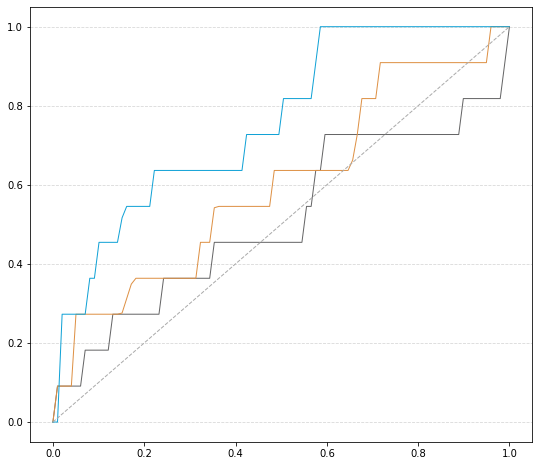

In [19]:
lw = 1

FONT_SIZE = 10
plt.rc("font", size=FONT_SIZE) # controls default text sizes
plt.rc("axes", titlesize=FONT_SIZE) # fontsize of the axes title
plt.rc("axes", labelsize=FONT_SIZE) # fontsize of the x and y labels
plt.rc("xtick", labelsize=FONT_SIZE) # fontsize of the tick labels
plt.rc("ytick", labelsize=FONT_SIZE) # fontsize of the tick labels
plt.rc("legend", fontsize=FONT_SIZE) # legend fontsize
plt.rc("figure", titlesize=FONT_SIZE) # fontsize of the figure title

color_gray, color_orange, color_blue = "#656566", "#de9145", "#11a2d6"
color_black = "#2a2a2a"

plt.figure(figsize=(9, 8))
plt.plot(mean_fpr, stroke_pp.pre_tprs, linestyle="-", lw=lw, alpha=1, color=color_gray)
plt.plot(mean_fpr, stroke_i.pre_tprs, linestyle="-", lw=lw, alpha=1, color=color_orange)
plt.plot(mean_fpr, stroke_pp.post_tprs, linestyle="-", lw=lw, alpha=1, color=color_blue)

red_patch = mpatches.Patch(
    color=color_gray,
    label="Preoperative factors\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(pre_auroc, 0.29680578, 0.72810082)
)
green_patch = mpatches.Patch(
    color=color_orange,
    label="Intraoperative factors\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(intra_auroc, 0.40866105, 0.78934643)
)
blue_patch = mpatches.Patch(
    color=color_blue,
    label="Integrated (preoperative factors and intraoperative factors)\nAUC={:.3f}  (CI={:.3f}—{:.3f})".format(post_auroc, 0.62102908, 0.89785843)
)

delong_patch = mpatches.Patch(
    color="white",
    label="\nDeLong's test\nPre vs Intra  Z={:.3f}  P={:.3f}\nPre vs Integrated  Z={:.3f}  P={:.3f}\nIntra vs Integrated  Z={:.3f}  P={:.3f}".format(p_i_delong_z, p_i_delong_p, p_pp_delong_z, p_pp_delong_p, i_pp_delong_z, i_pp_delong_p)
)

plt.plot([0, 1], [0, 1], linestyle="--", lw=lw, color="#ababab")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(True, axis="y", alpha=0.5, linestyle="dashed")
plt.show()

# Importance

In [20]:
import warnings
warnings.filterwarnings("ignore")  
np.seterr(divide = 'ignore')  

path_dataset = os.path.join(os.getcwd(), "data", "220321_SNUH_vitaldb_n42306_full.csv")
path_save = ""

stroke_p = SNUHStroke(kfold=True, model_save=False, debug=False, shap=True, feature_importance=True)
stroke_p.set_path(path_dataset, path_save)
stroke_p.load_dataset()
stroke_p.drop_exclusion()
stroke_p.set_features()
stroke_p.fill_features(mode="p")
stroke_p.compute_ttest()
stroke_p.train_test_split()

stroke_p.cores.check_label_ratio(stroke_p.df_train, "is_stroke")
stroke_p.cores.check_label_ratio(stroke_p.df_test, "is_stroke")

(42306,)
(18797, 135) (134, 135)
(18783, 135) (134, 135)
(18769, 135) (128, 135)
(18631, 135) (127, 135)
(18615, 135) (127, 135)
(18601, 135) (127, 135)
(18504, 135) (127, 135)
(15752, 30)
Data shape: (11557, 30) (4195, 30)
(11557, 28) (11557,) (4195, 28) (4195,)
is_stroke
    Total: 11557
    Nagatives: 11487
    Positives: 70 (0.61% of dataframe)

is_stroke
    Total: 4195
    Nagatives: 4156
    Positives: 39 (0.93% of dataframe)



In [21]:
# if you want recheck when lost connection
PATH_MODEL_SAVED = os.path.join(os.getcwd(), "model_0604v2", "stroke_p_cv5__rf_model_epoch06.pkl")
print(PATH_MODEL_SAVED)
stroke_p.recheck(PATH_MODEL_SAVED)

/home/wpkim/snuh/model_0604v2/stroke_p_cv5__rf_model_epoch06.pkl
/home/wpkim/snuh/model_0604v2/stroke_p_cv5__rf_model_epoch06.pkl


TypeError: compute_model_tprs() takes 4 positional arguments but 6 were given

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
p_fi = pd.concat(stroke_p.rf_feature_importance).reset_index(drop=True)
p_fi[1] = scaler.fit_transform(np.array(p_fi[1]).reshape(-1, 1))
p_fi = p_fi.rename(columns={0: "feature_names", 1: "feature_importances"})

scaler = MinMaxScaler()
p_pi = pd.concat(stroke_p.rf_permute_importance).reset_index(drop=True)
p_pi[1] = scaler.fit_transform(np.array(p_pi[1]).reshape(-1, 1))
p_pi = p_pi.rename(columns={1: "permutation_importances"})

scaler = MinMaxScaler()
p_shap = pd.concat(stroke_p.rf_shap).reset_index(drop=True)
p_shap["shap_importances"] = scaler.fit_transform(np.array(p_shap["shap_values"]).reshape(-1, 1))
p_shap = p_shap.sort_values("columns").reset_index(drop=True)

ValueError: No objects to concatenate

In [15]:
df_importances = pd.concat([p_fi, p_pi["permutation_importances"], p_shap["shap_importances"]], axis=1)

In [17]:
pd.DataFrame(np.array(stroke_p.rf_feature_importance).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)
pd.DataFrame(np.array(stroke_p.rf_permute_importance).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)
pd.DataFrame(np.array(stroke_p.rf_shap).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)

,0,1
0,age,0.036592
1,preop_hb_my,0.034409
2,preop_pt,0.029023
3,preop_alb,0.020718
4,preop_glucose_sm,0.020444
5,preop_ptt_sm,0.019675
6,preop_bun,0.018451
7,weight,0.016872
8,preop_egfr,0.015654
9,preop_got,0.015562


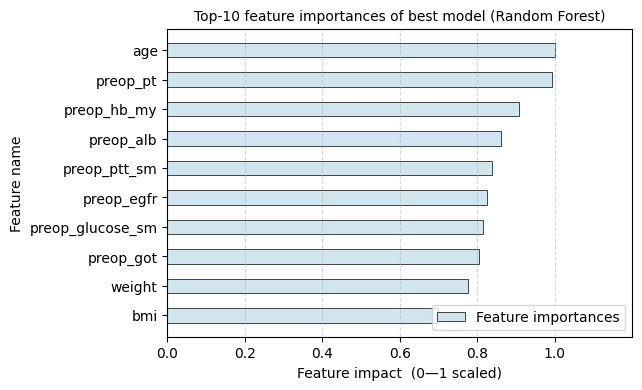

In [18]:
df_plot = df_importances.sort_values(by="feature_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y1 = np.array(df_plot.feature_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y1, height=w, label="Feature importances", edgecolor="black", linewidth=0.5, color="#d0e5ed")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

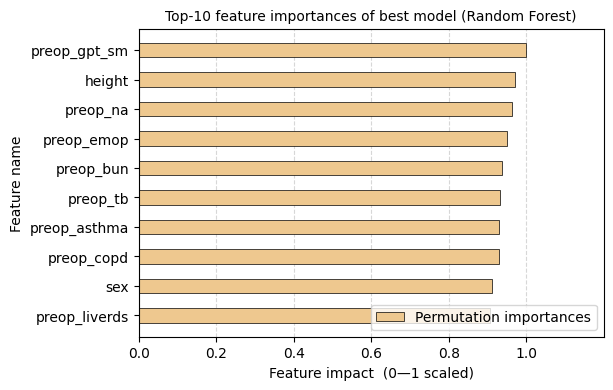

In [19]:
df_plot = df_importances.sort_values(by="permutation_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y2 = np.array(df_plot.permutation_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y2, height=w, label="Permutation importances", edgecolor="black", linewidth=0.5, color="#eec88f")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

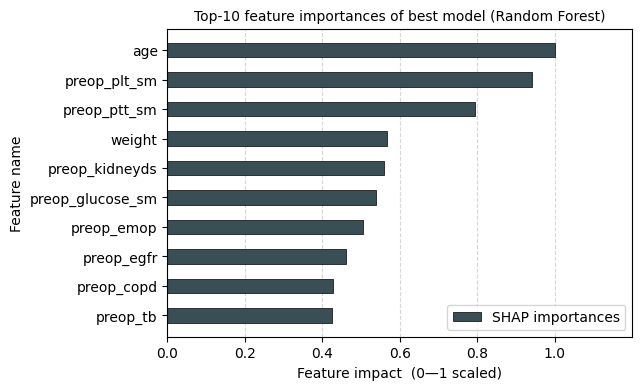

In [20]:
df_plot = df_importances.sort_values(by="shap_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y3 = np.array(df_plot.shap_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y3, height=w, label="SHAP importances", edgecolor="black", linewidth=0.5, color="#3a4e55")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

In [21]:
import warnings
warnings.filterwarnings("ignore")  ## inf warning 무시 (사실은 모든 경고를 끔)
np.seterr(divide = 'ignore')  ## divide by zero 무시

path_dataset = os.path.join(os.getcwd(), "data", "220321_SNUH_vitaldb_n42306_full.csv")
path_save = ""

stroke_i = SNUHStroke(kfold=True, model_save=False, debug=False, shap=True, feature_importance=True)
stroke_i.set_path(path_dataset, path_save)
stroke_i.load_dataset()
stroke_i.drop_exclusion()
stroke_i.set_features()
stroke_i.fill_features(mode="i")
stroke_i.compute_ttest()
stroke_i.train_test_split()

stroke_i.cores.check_label_ratio(stroke_i.df_train, "is_stroke")
stroke_i.cores.check_label_ratio(stroke_i.df_test, "is_stroke")

(42306,)
(18797, 135) (134, 135)
(18783, 135) (134, 135)
(18769, 135) (128, 135)
(18631, 135) (127, 135)
(18615, 135) (127, 135)
(18601, 135) (127, 135)
(18504, 135) (127, 135)
(15752, 63)
Data shape: (11557, 63) (4195, 63)
(11557, 61) (11557,) (4195, 61) (4195,)
is_stroke
    Total: 11557
    Nagatives: 11487
    Positives: 70 (0.61% of dataframe)

is_stroke
    Total: 4195
    Nagatives: 4156
    Positives: 39 (0.93% of dataframe)



In [22]:
# if you want recheck when lost connection
PATH_MODEL_SAVED = os.path.join(os.getcwd(), "model_0604v2", "stroke_i_cv5__rf_model_epoch12.pkl")
print(PATH_MODEL_SAVED)
stroke_i.recheck(PATH_MODEL_SAVED)

/home/wpkim/snuh/model_0604v2/stroke_i_cv5__rf_model_epoch12.pkl
/home/wpkim/snuh/model_0604v2/stroke_i_cv5__rf_model_epoch12.pkl


In [23]:
# pd.DataFrame(np.array(stroke_i.rf_feature_importance).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)
# pd.DataFrame(np.array(stroke_i.rf_permute_importance).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)
pd.DataFrame(np.array(stroke_i.rf_shap).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)

,0,1
0,sum_uo,0.035322
1,andur_cal_my,0.033014
2,sum_io,0.026564
3,opdur_cal_sm2,0.023786
4,SBP_mean,0.019589
...,...,...
56,sum_cryo,0.0
57,DBP_below30,0.0
58,DBP_below25,0.0
59,DBP_below20,0.0


In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
i_fi = pd.concat(stroke_i.rf_feature_importance).reset_index(drop=True)
i_fi[1] = scaler.fit_transform(np.array(i_fi[1]).reshape(-1, 1))
i_fi = i_fi.rename(columns={0: "feature_names", 1: "feature_importances"})

scaler = MinMaxScaler()
i_pi = pd.concat(stroke_i.rf_permute_importance).reset_index(drop=True)
i_pi[1] = scaler.fit_transform(np.array(i_pi[1]).reshape(-1, 1))
i_pi = i_pi.rename(columns={1: "permutation_importances"})

scaler = MinMaxScaler()
i_shap = pd.concat(stroke_i.rf_shap).reset_index(drop=True)
i_shap["shap_importances"] = scaler.fit_transform(np.array(i_shap["shap_values"]).reshape(-1, 1))
i_shap = i_shap.sort_values("columns").reset_index(drop=True)

In [25]:
df_importances = pd.concat([i_fi, i_pi["permutation_importances"], i_shap["shap_importances"]], axis=1)


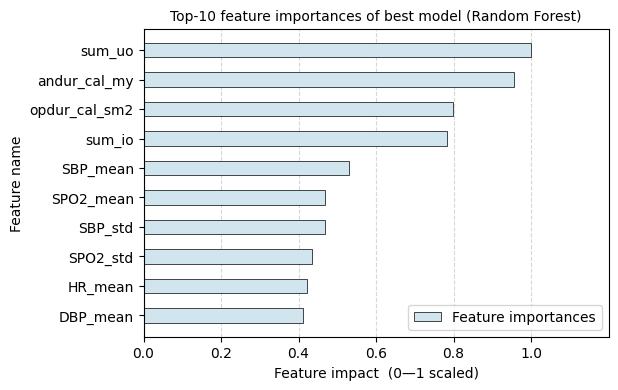

In [26]:
df_plot = df_importances.sort_values(by="feature_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y1 = np.array(df_plot.feature_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y1, height=w, label="Feature importances", edgecolor="black", linewidth=0.5, color="#d0e5ed")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

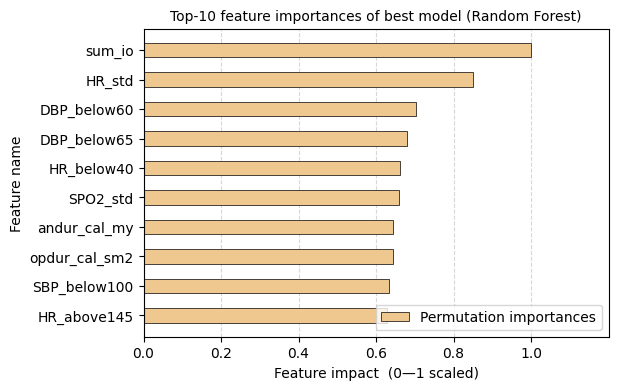

In [27]:
df_plot = df_importances.sort_values(by="permutation_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y2 = np.array(df_plot.permutation_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y2, height=w, label="Permutation importances", edgecolor="black", linewidth=0.5, color="#eec88f")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

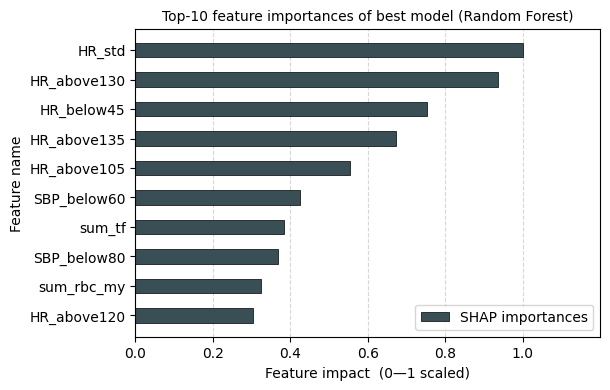

In [28]:
df_plot = df_importances.sort_values(by="shap_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y3 = np.array(df_plot.shap_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y3, height=w, label="SHAP importances", edgecolor="black", linewidth=0.5, color="#3a4e55")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

In [28]:
import warnings
warnings.filterwarnings("ignore")  
np.seterr(divide = 'ignore')  

path_dataset = os.path.join(os.getcwd(), "data", "220321_SNUH_vitaldb_n42306_full.csv")
path_save = ""

stroke_pp = SNUHStroke(kfold=True, model_save=False, debug=False, shap=True, feature_importance=True)
stroke_pp.set_path(path_dataset, path_save)
stroke_pp.load_dataset()
stroke_pp.drop_exclusion()
stroke_pp.set_features()
stroke_pp.fill_features(mode="pp")
stroke_pp.compute_ttest()
stroke_pp.train_test_split()

stroke_pp.cores.check_label_ratio(stroke_pp.df_train, "is_stroke")
stroke_pp.cores.check_label_ratio(stroke_pp.df_test, "is_stroke")

(42306,)
(18797, 135) (134, 135)
(18783, 135) (134, 135)
(18769, 135) (128, 135)
(18631, 135) (127, 135)
(18615, 135) (127, 135)
(18601, 135) (127, 135)
(18504, 135) (127, 135)
(15752, 91)
Data shape: (11557, 91) (4195, 91)
(11557, 89) (11557,) (4195, 89) (4195,)
is_stroke
    Total: 11557
    Nagatives: 11487
    Positives: 70 (0.61% of dataframe)

is_stroke
    Total: 4195
    Nagatives: 4156
    Positives: 39 (0.93% of dataframe)



In [29]:
# if you want recheck when lost connection
PATH_MODEL_SAVED = os.path.join(os.getcwd(), "model_0604v2", "stroke_pp_cv5__rf_model_epoch12.pkl")
print(PATH_MODEL_SAVED)
stroke_pp.recheck(PATH_MODEL_SAVED)

/home/wpkim/snuh/model_0604v2/stroke_pp_cv5__rf_model_epoch12.pkl
/home/wpkim/snuh/model_0604v2/stroke_pp_cv5__rf_model_epoch12.pkl


In [30]:
pd.DataFrame(np.array(stroke_pp.rf_feature_importance).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)
# pd.DataFrame(np.array(stroke_pp.rf_permute_importance).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)
# pd.DataFrame(np.array(stroke_pp.rf_shap).reshape(-1, 2)).sort_values(by=1, ascending=False).reset_index(drop=True)

,0,1
0,sum_uo,0.051541
1,sum_io,0.036662
2,SPO2_below95,0.032075
3,andur_cal_my,0.031682
4,weight,0.03067
...,...,...
84,sum_cryo,0.0
85,sum_plt,0.0
86,sum_ffp,0.0
87,DBP_below20,0.0


In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pp_fi = pd.concat(stroke_pp.rf_feature_importance).reset_index(drop=True)
pp_fi[1] = scaler.fit_transform(np.array(pp_fi[1]).reshape(-1, 1))
pp_fi = pp_fi.rename(columns={0: "feature_names", 1: "feature_importances"})

scaler = MinMaxScaler()
pp_pi = pd.concat(stroke_pp.rf_permute_importance).reset_index(drop=True)
pp_pi[1] = scaler.fit_transform(np.array(pp_pi[1]).reshape(-1, 1))
pp_pi = pp_pi.rename(columns={1: "permutation_importances"})

scaler = MinMaxScaler()
pp_shap = pd.concat(stroke_pp.rf_shap).reset_index(drop=True)
pp_shap["shap_importances"] = scaler.fit_transform(np.array(pp_shap["shap_values"]).reshape(-1, 1))
pp_shap = pp_shap.sort_values("columns").reset_index(drop=True)

In [32]:
df_importances = pd.concat([pp_fi, pp_pi["permutation_importances"], pp_shap["shap_importances"]], axis=1)


In [40]:
FONT_SIZE = 10
plt.rc("font", size=FONT_SIZE) # controls default text sizes
plt.rc("axes", titlesize=FONT_SIZE) # fontsize of the axes title
plt.rc("axes", labelsize=FONT_SIZE) # fontsize of the x and y labels
plt.rc("xtick", labelsize=FONT_SIZE) # fontsize of the tick labels
plt.rc("ytick", labelsize=FONT_SIZE) # fontsize of the tick labels
plt.rc("legend", fontsize=FONT_SIZE) # legend fontsize
plt.rc("figure", titlesize=FONT_SIZE) # fontsize of the figure title

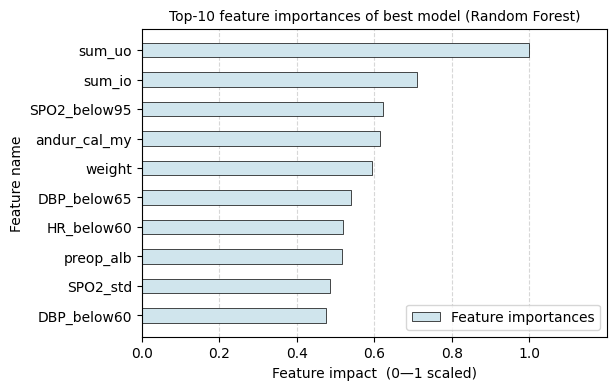

In [41]:
df_plot = df_importances.sort_values(by="feature_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y1 = np.array(df_plot.feature_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y1, height=w, label="Feature importances", edgecolor="black", linewidth=0.5, color="#d0e5ed")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

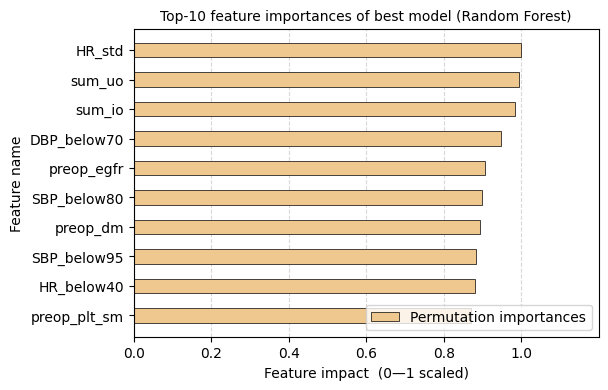

In [42]:
df_plot = df_importances.sort_values(by="permutation_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y2 = np.array(df_plot.permutation_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y2, height=w, label="Permutation importances", edgecolor="black", linewidth=0.5, color="#eec88f")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

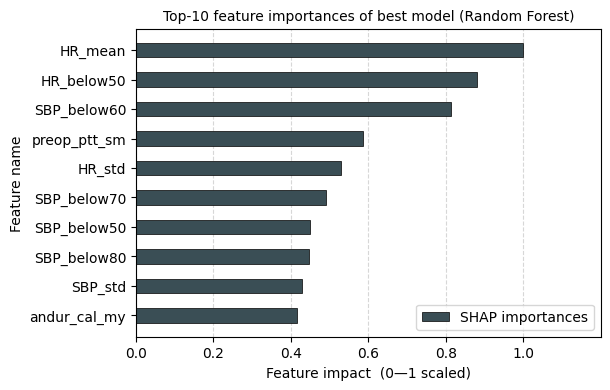

In [43]:
df_plot = df_importances.sort_values(by="shap_importances", ascending=False)
df_plot = df_plot[:10]

X = np.arange(0, df_plot.shape[0])
y3 = np.array(df_plot.shap_importances)

w = 0.5
plt.figure(figsize=(6, 4))

plt.barh(X, y3, height=w, label="SHAP importances", edgecolor="black", linewidth=0.5, color="#3a4e55")

plt.xlim([0, 1.2])
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
# plt.yticks(X, labels=["HR Avg", "HR <50", "SBP <60", "PTT", "HR Std", "SBP <70", "SBP <50", "SBP <80", "SBP Std", "Andur"], rotation=0)
plt.yticks(X, labels=df_plot.feature_names, rotation=0)
plt.margins(y=0.05)
plt.legend(loc="lower right")
plt.title("Top-10 feature importances of best model (Random Forest)")
plt.xlabel("Feature impact  (0—1 scaled)")
plt.ylabel("Feature name")
plt.grid(True, axis="x", alpha=0.5, linestyle="dashed")
plt.rcParams["axes.axisbelow"] = True
plt.gca().invert_yaxis()
plt.show()

In [233]:
 def compute_youden_index(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auroc = auc(fpr, tpr)

    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]

    y_pred = (y_pred >= best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    sen = tp / (tp + fn)
    spe = tn / (tn + fp)

    ppv = tp / (tp + fp)
    npv = tn / (tn + tn)
    print("ppv={:.3f} npv={:.3f}".format(ppv, npv))

    odd_ratio = (tp * tn) / (fp * fn)
    print("odd_ratio={:.3f}".format(odd_ratio))

    mean_fpr = np.linspace(0, 1, 100)

    tprs = []
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    tprs = np.mean(tprs, axis=0)

    return tprs, fpr, tpr, auroc, best_threshold, ix, sen, spe

ppv=0.018 npv=0.500
odd_ratio=2.459
ppv=0.022 npv=0.500
odd_ratio=8.761
ppv=0.035 npv=0.500
odd_ratio=12.241


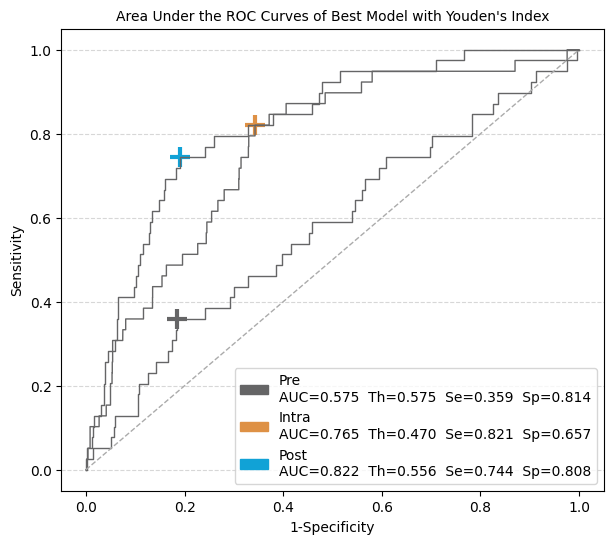

In [234]:
p_model = joblib.load(os.path.join(os.getcwd(), "model_0604v2", "stroke_p_cv5__rf_model_epoch06.pkl"))
i_model = joblib.load(os.path.join(os.getcwd(), "model_0604v2", "stroke_i_cv5__rf_model_epoch12.pkl"))
pp_model = joblib.load(os.path.join(os.getcwd(), "model_0604v2", "stroke_pp_cv5__rf_model_epoch12.pkl"))

_, p_fpr, p_tpr, p_auc, p_threshold, p_ix, p_sen, p_spe = compute_youden_index(p_model, stroke_p.X_test, stroke_p.y_test)
_, i_fpr, i_tpr, i_auc, i_threshold, i_ix, i_sen, i_spe = compute_youden_index(i_model, stroke_i.X_test, stroke_i.y_test)
_, pp_fpr, pp_tpr, pp_auc, pp_threshold, pp_ix, pp_sen, pp_spe = compute_youden_index(pp_model, stroke_pp.X_test, stroke_pp.y_test)

lw = 1

FONT_SIZE = 10
plt.rc("font", size=FONT_SIZE) # controls default text sizes
plt.rc("axes", titlesize=FONT_SIZE) # fontsize of the axes title
plt.rc("axes", labelsize=FONT_SIZE) # fontsize of the x and y labels
plt.rc("xtick", labelsize=FONT_SIZE) # fontsize of the tick labels
plt.rc("ytick", labelsize=FONT_SIZE) # fontsize of the tick labels
plt.rc("legend", fontsize=FONT_SIZE) # legend fontsize
plt.rc("figure", titlesize=FONT_SIZE) # fontsize of the figure title

color_gray, color_orange, color_blue = "#656566", "#de9145", "#11a2d6"
color_black = "#2a2a2a"

plt.figure(figsize=(7, 6))
plt.plot(p_fpr, p_tpr, linestyle="-", lw=lw, alpha=1, color=color_gray)
plt.plot(i_fpr, i_tpr, linestyle="-", lw=lw, alpha=1, color=color_gray)
plt.plot(pp_fpr, pp_tpr, linestyle="-", lw=lw, alpha=1, color=color_gray)

plt.scatter(p_fpr[p_ix], p_tpr[p_ix], marker="+", s=200, lw=3, color=color_gray)
plt.scatter(i_fpr[i_ix], i_tpr[i_ix], marker="+", s=200, lw=3, color=color_orange)
plt.scatter(pp_fpr[pp_ix], pp_tpr[pp_ix], marker="+", s=200, lw=3, color=color_blue)

p_patch = mpatches.Patch(color=color_gray, label="Pre\nAUC={:.3f}  Th={:.3f}  Se={:.3f}  Sp={:.3f}".format(p_auc, p_threshold, p_sen, p_spe))
i_patch = mpatches.Patch(color=color_orange, label="Intra\nAUC={:.3f}  Th={:.3f}  Se={:.3f}  Sp={:.3f}".format(i_auc, i_threshold, i_sen, i_spe))
pp_patch = mpatches.Patch(color=color_blue, label="Post\nAUC={:.3f}  Th={:.3f}  Se={:.3f}  Sp={:.3f}".format(pp_auc, pp_threshold, pp_sen, pp_spe))

plt.plot([0, 1], [0, 1], linestyle="--", lw=lw, color="#ababab")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right", handles=[p_patch, i_patch, pp_patch, ])
plt.title("Area Under the ROC Curves of Best Model with Youden's Index")
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.grid(True, axis="y", alpha=0.5, linestyle="dashed")
plt.show()

ppv=0.052 npv=0.500
odd_ratio=2.611
ppv=0.120 npv=0.500
odd_ratio=7.091
ppv=0.041 npv=0.500
odd_ratio=inf


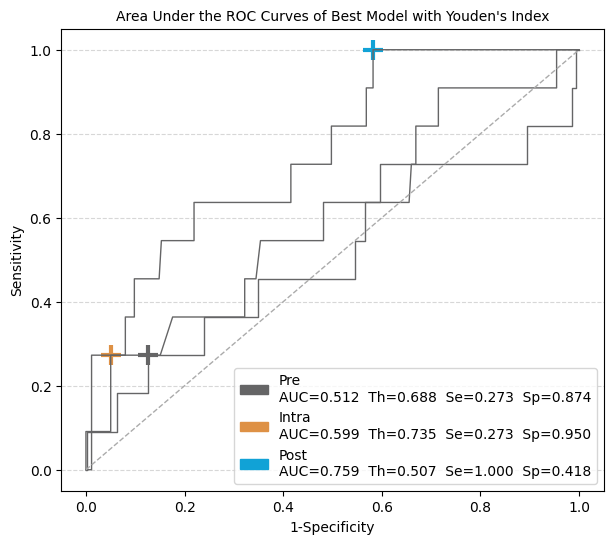

In [244]:
p_model = joblib.load(os.path.join(os.getcwd(), "model_0604v2", "stroke_p_cv5__rf_model_epoch06.pkl"))
i_model = joblib.load(os.path.join(os.getcwd(), "model_0604v2", "stroke_i_cv5__rf_model_epoch12.pkl"))
pp_model = joblib.load(os.path.join(os.getcwd(), "model_0604v2", "stroke_pp_cv5__rf_model_epoch12.pkl"))

_, p_fpr, p_tpr, p_auc, p_threshold, p_ix, p_sen, p_spe = compute_youden_index(p_model, stroke_p.X_test, stroke_p.y_test)
_, i_fpr, i_tpr, i_auc, i_threshold, i_ix, i_sen, i_spe = compute_youden_index(i_model, stroke_i.X_test, stroke_i.y_test)
_, pp_fpr, pp_tpr, pp_auc, pp_threshold, pp_ix, pp_sen, pp_spe = compute_youden_index(pp_model, stroke_pp.X_test, stroke_pp.y_test)

lw = 1

FONT_SIZE = 10
plt.rc("font", size=FONT_SIZE) # controls default text sizes
plt.rc("axes", titlesize=FONT_SIZE) # fontsize of the axes title
plt.rc("axes", labelsize=FONT_SIZE) # fontsize of the x and y labels
plt.rc("xtick", labelsize=FONT_SIZE) # fontsize of the tick labels
plt.rc("ytick", labelsize=FONT_SIZE) # fontsize of the tick labels
plt.rc("legend", fontsize=FONT_SIZE) # legend fontsize
plt.rc("figure", titlesize=FONT_SIZE) # fontsize of the figure title

color_gray, color_orange, color_blue = "#656566", "#de9145", "#11a2d6"
color_black = "#2a2a2a"

plt.figure(figsize=(7, 6))
plt.plot(p_fpr, p_tpr, linestyle="-", lw=lw, alpha=1, color=color_gray)
plt.plot(i_fpr, i_tpr, linestyle="-", lw=lw, alpha=1, color=color_gray)
plt.plot(pp_fpr, pp_tpr, linestyle="-", lw=lw, alpha=1, color=color_gray)

plt.scatter(p_fpr[p_ix], p_tpr[p_ix], marker="+", s=200, lw=3, color=color_gray)
plt.scatter(i_fpr[i_ix], i_tpr[i_ix], marker="+", s=200, lw=3, color=color_orange)
plt.scatter(pp_fpr[pp_ix], pp_tpr[pp_ix], marker="+", s=200, lw=3, color=color_blue)

p_patch = mpatches.Patch(color=color_gray, label="Pre\nAUC={:.3f}  Th={:.3f}  Se={:.3f}  Sp={:.3f}".format(p_auc, p_threshold, p_sen, p_spe))
i_patch = mpatches.Patch(color=color_orange, label="Intra\nAUC={:.3f}  Th={:.3f}  Se={:.3f}  Sp={:.3f}".format(i_auc, i_threshold, i_sen, i_spe))
pp_patch = mpatches.Patch(color=color_blue, label="Post\nAUC={:.3f}  Th={:.3f}  Se={:.3f}  Sp={:.3f}".format(pp_auc, pp_threshold, pp_sen, pp_spe))

plt.plot([0, 1], [0, 1], linestyle="--", lw=lw, color="#ababab")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right", handles=[p_patch, i_patch, pp_patch, ])
plt.title("Area Under the ROC Curves of Best Model with Youden's Index")
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.grid(True, axis="y", alpha=0.5, linestyle="dashed")
plt.show()

In [236]:
def plot_youden_index(self, rf_path, xgb_path, lgb_path, title):
    rf_model = joblib.load(rf_path)
    xgb_model = joblib.load(xgb_path)
    lgb_model = joblib.load(lgb_path)

    rf_tprs, rf_fpr, rf_tpr, rf_auroc, rf_thr, rf_ix, rf_sen, rf_spe = self.cores.compute_youden_index(rf_model, self.X_test, self.y_test)
    xgb_tprs, xgb_fpr, xgb_tpr, xgb_auroc, xgb_thr, xgb_ix, xgb_sen, xgb_spe = self.cores.compute_youden_index(xgb_model, self.X_test, self.y_test)
    lgb_tprs, lgb_fpr, lgb_tpr, lgb_auroc, lgb_thr, lgb_ix, lgb_sen, lgb_spe = self.cores.compute_youden_index(lgb_model, self.X_test, self.y_test)

    lw = 1

    FONT_SIZE = 10
    plt.rc("font", size=FONT_SIZE) # controls default text sizes
    plt.rc("axes", titlesize=FONT_SIZE) # fontsize of the axes title
    plt.rc("axes", labelsize=FONT_SIZE) # fontsize of the x and y labels
    plt.rc("xtick", labelsize=FONT_SIZE) # fontsize of the tick labels
    plt.rc("ytick", labelsize=FONT_SIZE) # fontsize of the tick labels
    plt.rc("legend", fontsize=FONT_SIZE) # legend fontsize
    plt.rc("figure", titlesize=FONT_SIZE) # fontsize of the figure title

    color_r, color_g, color_b = "crimson", "darkgreen", "darkblue"

    plt.figure(figsize=(7, 6))

    plt.plot([0, 1], [0, 1], linestyle="--", lw=lw, color="k")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("1-Specificity")
    plt.ylabel("Sensitivity")
    plt.title(title)

    red_patch = mpatches.Patch(
        color=color_r,
        label="RandomForest\nAUC={:.3f} Th={:.3f} Se={:.3f} Sp={:.3f}".format(rf_auroc, rf_thr, rf_sen, rf_spe)
    )
    green_patch = mpatches.Patch(
        color=color_g,
        label="XGBoost\nAUC={:.3f} Th={:.3f} Se={:.3f} Sp={:.3f}".format(xgb_auroc, xgb_thr, xgb_sen, xgb_spe)
    )
    blue_patch = mpatches.Patch(
        color=color_b,
        label="LightGBM\nAUC={:.3f} Th={:.3f} Se={:.3f} Sp={:.3f}".format(lgb_auroc, lgb_thr, lgb_sen, lgb_spe)
    )

    plt.legend(loc="lower right", handles=[red_patch, green_patch, blue_patch])
    plt.show()